# Analysis of Medieval Arabic Creations

This notebook presents the implementation phase of a research project focused on authorship attribution of medieval Arabic texts, with a particular emphasis on texts attributed to the Islamic scholar Abu Hamid Al-Ghazali.
The goal is to determine the authenticity of these texts by applying modern Natural Language Processing (NLP) techniques adapted to the linguistic and stylistic characteristics of classical Arabic. The project aims to develop a robust computational framework capable of distinguishing authentic works from those falsely attributed, by analyzing and comparing textual patterns across known and disputed writings.

## Pipeline Overview

The implementation consists of the following steps:

1. **Preprocessing:** Normalizing and cleaning Arabic texts using CAMeL Tools, stopword removal, and morphological adjustments.
2. **Batching:** Splitting each document into fixed-length segments (e.g., 50-token batches).
3. **Fine-tuning AraBERT:** Adapting the pre-trained AraBERT model on a domain-specific corpus using masked language modeling to improve embedding quality for medieval Arabic.
4. **Embedding Extraction:** Generating dense vector representations for each text batch using the fine-tuned model.
5. **Siamese Network Training:** Using a CNN-BiLSTM Siamese architecture to measure stylistic similarity between pairs of texts.
6. **Similarity Assessment:** Comparing embeddings using distance metrics and applying the Impostors Method to distinguish between authentic and inauthentic texts.
7. **Classification and Clustering:** Applying Dynamic Time Warping, Isolation Forest, and clustering techniques to evaluate and visualize authorship patterns.

## Tools and Frameworks

- Python (Google Colab)
- CAMeL Tools for Arabic NLP
- HuggingFace Transformers (AraBERT)
- PyTorch
- CNN + BiLSTM Siamese Networks
- Dynamic Time Warping, Isolation Forest, K-means Clustering



## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


## Environment Setup

This cell installs all the required libraries for the authorship verification pipeline based on AraBERT and Siamese networks.

- **CAMeL Tools (`camel-tools[cli,morphology,tok]`)** – Used for Arabic text preprocessing, including tokenization and morphological analysis. We use a lightweight configuration that avoids unnecessary language modeling components.
- **Support packages** – `docopt`, `muddler`, `emoji`, `dill`, and `pyrsistent` are dependencies required by CAMeL Tools and for object serialization.
- **Core libraries** – `pandas`, `matplotlib`, `torch`, `scikit-learn`, and `fastdtw` support data manipulation, modeling, visualization, and Dynamic Time Warping computations.
- **Hugging Face ecosystem** – `datasets`, `accelerate`, and `transformers` are used for model loading, dataset management, and efficient training with AraBERT.

In [ ]:
!pip install camel-tools[cli,morphology,tok]==1.5.5
!pip install docopt muddler emoji==2.14.1 dill==0.3.9 pyrsistent==0.20.0
!pip install pandas matplotlib torch scikit-learn fastdtw
!pip install datasets==2.14.5 accelerate==0.27.2
!pip install transformers==4.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542081 sha256=24863b070e8cab7b71d2582a076e0715d9e469dd8c51f1a80875e0732da79c36
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
  Using cached datasets-2.14.5-py3-none-any.whl.metadata (19 kB)
  Using cached accelerate-0.27.2-py3-none-any.whl.metadata (18 kB)
  Using cached dill-0.3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached fsspec-2023.6.0-py3-none-any.whl.metadata (6.7 kB)
Using cached datasets-2.14.5-py3-none-any.whl (519 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall:

## Library Imports and CAMeL Tools Setup

This cell imports the essential Python libraries used throughout the project:
- **Core libraries**: `os`, `re`, and `pandas` for file handling, text processing, and data manipulation.
- **Visualization**: `matplotlib.pyplot` for generating plots.
- **PyTorch**: Used to define, train, and evaluate the Siamese neural network.
- **Scikit-learn**: Provides utility functions such as `train_test_split` for partitioning the dataset.

Additionally, it imports components from **CAMeL Tools**, a toolkit for Arabic natural language processing:
- `dediac_ar`: Removes diacritics from Arabic text.
- `normalize_*`: Normalizes specific Arabic characters, such as Alef variants, Alef Maqsura, and Teh Marbuta.
- `simple_word_tokenize`: Splits Arabic sentences into individual word tokens.



In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.utils.normalize import (
    normalize_alef_ar,
    normalize_alef_maksura_ar,
    normalize_teh_marbuta_ar
)
from camel_tools.utils.dediac import dediac_ar
print("CAMeL Tools imported successfully.")


CAMeL Tools imported successfully.


## Arabic Text Preprocessing

This cell defines a custom stopword list and a `preprocess_arabic_text()` function to prepare Arabic text for further processing. The preprocessing steps include:

1. **Tokenization** – Splits the input text into tokens using CAMeL Tools' `simple_word_tokenize`.
2. **Stopword Removal** – Eliminates common Arabic words (e.g., prepositions and pronouns) that typically do not contribute to authorship distinction.
3. **Normalization & Cleaning**:
   - Normalizes different forms of Alef, Alef Maqsura, and Teh Marbuta.
   - Removes diacritics.
   - Filters out non-Arabic characters, including punctuation and numbers.

The function returns a space-separated string of cleaned, normalized Arabic tokens.

In [ ]:
# Custom minimal stopword list (you can expand later)
custom_stopwords = set([
    'في', 'من', 'على', 'إلى', 'عن', 'هو', 'هي', 'هذا', 'هذه', 'ذلك', 'تلك',
    'ما', 'ماذا', 'لماذا', 'متى', 'أين', 'كيف', 'هل', 'لا', 'نعم', 'أنا',
    'نحن', 'أنت', 'أنتم', 'إن', 'كان', 'يا'
])

def preprocess_arabic_text(text):
    """
    Clean classical Arabic text: remove diacritics, punctuation, Latin/digits,
    normalize letter variants, remove stopwords, and filter junk.
    """
    if not isinstance(text, str):
        raise ValueError("Input must be a string")

    # 1. Remove spaced-letter sequences (e.g. ا ل د ن ي ا)
    text = re.sub(r'(?:\b[\u0621-\u064A]\s){2,}[\u0621-\u064A]\b', ' ', text)

    # 2. Remove Arabic punctuation and Tatweel
    text = re.sub(r'[،؛؟ـ“”‘’…«»‹›⸮]', '', text)

    # 3. Remove digits, Latin characters, symbols
    text = re.sub(r'[^\u0621-\u064A\s]', ' ', text)

    # 4. Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Tokenize
    tokens = simple_word_tokenize(text)

    # 6. Remove stopwords and filter short garbage
    filtered_tokens = [
        tok for tok in tokens
        if tok not in custom_stopwords and (len(tok) > 1 or tok in {'لا', 'ما', 'إن'})
    ]

    # 7. Normalize and dediacritize
    normalized = []
    for tok in filtered_tokens:
        tok = normalize_alef_ar(tok)
        tok = normalize_alef_maksura_ar(tok)
        tok = normalize_teh_marbuta_ar(tok)
        tok = dediac_ar(tok)
        if tok.strip():
            normalized.append(tok)

    return ' '.join(normalized)

### Preprocessing the Impostor Group

This cell defines a function `process_impostors_group_flat()` that:

1. **Recursively iterates** over subfolders (authors) inside the input directory.
2. **Loads each `.txt` file**, applies Arabic preprocessing using `preprocess_arabic_text()`.
3. **Writes cleaned outputs** into a mirrored directory structure under a new output path.

In [ ]:
def process_impostors_group_flat(input_root, output_root):
    """
    Applies preprocessing to all .txt files inside each author's folder and saves the cleaned output.

    Folder Structure Expected:
        input_root/
            author1/
                impostor1.txt
                impostor2.txt
            author2/
                impostor1.txt

    Output Structure:
        output_root/
            author1/
                impostor1_cleaned.txt
            author2/
                impostor1_cleaned.txt
    """
    total = 0  # counter for reporting

    # Loop through each author folder
    for author in os.listdir(input_root):
        author_dir = os.path.join(input_root, author)
        if not os.path.isdir(author_dir):
            continue

        # Process each text file in the author's folder
        for fname in os.listdir(author_dir):
            if not fname.endswith(".txt"):
                continue

            input_path = os.path.join(author_dir, fname)
            base_name = os.path.splitext(fname)[0]
            cleaned_name = f"{base_name}_cleaned.txt"
            output_path = os.path.join(output_root, author, cleaned_name)

            try:
                # Load raw text
                with open(input_path, 'r', encoding='utf-8') as f:
                    raw = f.read()

                # Preprocess text
                cleaned = preprocess_arabic_text(raw)

                # Ensure output folder exists
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # Save cleaned output
                with open(output_path, 'w', encoding='utf-8') as f:
                    f.write(cleaned)

                print(f"Cleaned: {author}/{cleaned_name}")
                total += 1

            except Exception as e:
                print(f"Error processing {input_path}: {e}")

    print(f"\nTotal cleaned files: {total}")

# === Set your paths and run preprocessing ===
input_dir = "/content/drive/MyDrive/impostors_group"
output_dir = "/content/drive/MyDrive/impostors_clean"
process_impostors_group_flat(input_dir, output_dir)

Cleaned: author 6/author6_impostor_3_cleaned.txt
Cleaned: author 6/author6_impostor_1_cleaned.txt
Cleaned: author 6/author6_impostor_2_cleaned.txt
Cleaned: author 5/author5_impostor_1_cleaned.txt
Cleaned: author 5/author5_impostor_2_cleaned.txt
Cleaned: author 3/author3_impostor_2_cleaned.txt
Cleaned: author 3/author3_impostor_3_cleaned.txt
Cleaned: author 3/author3_impostor_1_cleaned.txt
Cleaned: author 1/author1_impostor_1_cleaned.txt
Cleaned: author 1/author1_impostor_2_cleaned.txt
Cleaned: author 8/author8_impostor_1_cleaned.txt
Cleaned: author 8/author8_impostor_3_cleaned.txt
Cleaned: author 8/author8_impostor_2_cleaned.txt
Cleaned: author 7/author7_impostor_2_cleaned.txt
Cleaned: author 7/author7_impostor_1_cleaned.txt
Cleaned: author 9/author9_impostor_2_cleaned.txt
Cleaned: author 9/author9_impostor_1_cleaned.txt
Cleaned: author 10/author10_impostor_3_cleaned.txt
Cleaned: author 10/author10_impostor_2_cleaned.txt
Cleaned: author 10/author10_impostor_1_cleaned.txt
Cleaned: autho

### Preprocessing the Test Group

This cell defines a function `process_test_group()` to clean all `.txt` files in a test set directory. The process:

1. **Reads each file** from the specified `input_dir`.
2. **Applies Arabic text preprocessing** using the `preprocess_arabic_text()` function.
3. **Saves cleaned versions** in the specified `output_dir` with `_cleaned.txt` suffix.


In [ ]:
def process_test_group(input_dir, output_dir):
    """
    Preprocess all .txt files in `input_dir` and save cleaned outputs to `output_dir`.

    Args:
        input_dir (str): Folder containing raw test .txt files.
        output_dir (str): Folder to store cleaned test files.
    """
    os.makedirs(output_dir, exist_ok=True)
    total = 0  # Counter for processed files

    for fname in os.listdir(input_dir):
        if not fname.endswith('.txt'):
            continue

        input_path = os.path.join(input_dir, fname)
        base_name = os.path.splitext(fname)[0]
        output_file = f"{base_name}_cleaned.txt"
        output_path = os.path.join(output_dir, output_file)

        try:
            with open(input_path, 'r', encoding='utf-8') as f:
                raw = f.read()

            cleaned = preprocess_arabic_text(raw)

            with open(output_path, 'w', encoding='utf-8') as f:
                f.write(cleaned)

            print(f"Cleaned: {fname}")
            total += 1

        except Exception as e:
            print(f"Error processing {fname}: {e}")

    print(f"\nTotal cleaned test files: {total}")

# Set your input and output directory paths
test_input = "/content/drive/MyDrive/test_group"
test_output = "/content/drive/MyDrive/test_clean"

# Run the cleaning process
process_test_group(test_input, test_output)

Cleaned: Iḥyāʾ ʿUlūm Al-Dīn20.txt
Cleaned: Shifāʾ al-Ghalīl fī Bayān al-Shubah wa al-Mukhīl wa Masālik al-Taʿlīl1.txt
Cleaned: Shifāʾ al-Ghalīl fī Bayān al-Shubah wa al-Mukhīl wa Masālik al-Taʿlīl2.txt
Cleaned: Al-Wasīṭ fī al-Madhhab28.txt
Cleaned: Mīzān al-ʿAmal2.txt
Cleaned: Iḥyāʾ ʿUlūm Al-Dīn3.txt
Cleaned: Iḥyāʾ ʿUlūm Al-Dīn27.txt
Cleaned: Iḥyāʾ ʿUlūm Al-Dīn11.txt
Cleaned: Fayṣal Al-Tafriqa Fī Al-Islām Wa Al-Zanādiqa.txt
Cleaned: Shifāʾ al-Ghalīl fī Bayān al-Shubah wa al-Mukhīl wa Masālik al-Taʿlīl5.txt
Cleaned: Al-Wasīṭ fī al-Madhhab25.txt
Cleaned: Al-Risāla Al-Waʿẓiyya.txt
Cleaned: Iḥyāʾ ʿUlūm Al-Dīn45.txt
Cleaned: Al-Mustasfa Fi ʿIlm Al-Uṣūl21.txt
Cleaned: Risālat al-Ṭayr Dhikr al-ʿAnqāʾ.txt
Cleaned: Iḥyāʾ ʿUlūm Al-Dīn25.txt
Cleaned: Al-Mankhūl min Taʿlīqāt al-Uṣūl1.txt
Cleaned: Al-Mustasfa Fi ʿIlm Al-Uṣūl9.txt
Cleaned: Al-Wasīṭ fī al-Madhhab5.txt
Cleaned: Iḥyāʾ ʿUlūm Al-Dīn37.txt
Cleaned: Al-Wasīṭ fi

## Global Configuration Parameters

In [ ]:
import os

# ========== Fine-Tuning AraBERT ==========

# Model and tokenizer name
ARABERT_MODEL_NAME = "aubmindlab/bert-base-arabertv2"

# Paths for loading data and saving outputs
CLEAN_DIRS = [
    "/content/drive/MyDrive/impostors_clean",
    "/content/drive/MyDrive/test_clean"
]
FINETUNED_MODEL_PATH = "/content/drive/MyDrive/arabert-finetuned-medieval"
ARABERT_LOGGING_DIR = "/content/drive/MyDrive/logs-medieval"

# Tokenization settings
MAX_SEQ_LENGTH = 128
MLM_PROBABILITY = 0.15

# Training hyperparameters
TRAIN_BATCH_SIZE = 8
NUM_TRAIN_EPOCHS = 10
SAVE_STEPS = 500
SAVE_TOTAL_LIMIT = 2
LOGGING_STEPS = 100


# ========== Generate CLS Embeddings for Test Texts ==========

# Test files location and where to save embeddings
TEST_EMBEDDINGS_DIR =  "/content/drive/MyDrive/test_embeddings"
os.makedirs(TEST_EMBEDDINGS_DIR, exist_ok=True)


# Maximum number of tokens passed to the tokenizer for CLS embedding
MAX_TOKEN_LENGTH = 128

# Text segmentation
SEGMENT_SIZE = 50  # Number of words per batch
MIN_BATCH_WORDS = 10  # Minimum words to keep the segment

# ========== Core Layer ==========

# CNN & BiLSTM architecture
SEQ_LEN = 64  # Input embedding is reshaped into a sequence of 16 time steps
CNN_KERNEL_SIZES = [3, 6, 12]  # Using multiple kernel sizes in parallel
CNN_OUT_CHANNELS = 300  # Number of filters for each kernel size
CNN_DROPOUT = 0.25

LSTM_NUM_LAYERS = 2

LSTM_HIDDEN_SIZE = 300
LSTM_DROPOUT = 0.25

# Training loop
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 1e-5

# Tokenization
MAX_TOKEN_LENGTH = 128  # Maximum tokens for BERT input

# Signal processing
TEST_BATCH_SIZE = 50
MIN_VALID_BATCH_LEN = 10
CHUNKSIZE = 8

# Directory paths
IMPOSTOR_RESULTS_DIR = "/content/drive/MyDrive/impostor_results"


# ========== DTW ==========

DTW_OUTPUT_DIR = os.path.join(IMPOSTOR_RESULTS_DIR, "dtw_matrices")
SIGNAL_DIR = os.path.join(IMPOSTOR_RESULTS_DIR, "signals")
INDEX_FILE_PATH = "/content/drive/MyDrive/test_group_index.csv"
DTW_HEATMAP_FIGSIZE = (40, 40)  # Larger for better readability with 41 books
DTW_FONT_SIZE = 18  # Larger for clearer indices
DTW_NUMBER_FONT_SIZE = 14  # Larger for matrix values
DTW_COLORBAR_FONT_SIZE = 24  # Larger for colorbar labels
DTW_COLOR_MAP = "viridis"  # Original color map for better contrast
MEAN_DTW_COLOR_MAP = "plasma"
DTW_EPSILON = 1e-8  # to prevent division by zero in normalization


# ========== Isolation Forest  ==========

ISOLATION_OUTPUT_DIR = os.path.join(IMPOSTOR_RESULTS_DIR, "isolation_forest_output")
ISOLATION_SCORES_DIR = os.path.join(IMPOSTOR_RESULTS_DIR, "isolation_forest_output_scores")
ISOLATION_PLOTS_DIR = os.path.join(ISOLATION_OUTPUT_DIR, "plots")
ISOLATION_CSV_DIR = os.path.join(ISOLATION_OUTPUT_DIR, "csv")

ISOLATION_N_ESTIMATORS = 500  # Increased for more stable results
ISOLATION_CONTAMINATION = 'auto'
ISOLATION_RANDOM_STATE = 42
ISOLATION_PCA_COMPONENTS = 2

HEATMAP_WIDTH = 8
HEATMAP_BASE_HEIGHT = 5
HEATMAP_HEIGHT_PER_BOOK = 0.4

# ========== Clustering  ==========

CLUSTERING_OUTPUT_DIR = "/content/drive/MyDrive/clustering_results"
os.makedirs(CLUSTERING_OUTPUT_DIR, exist_ok=True)

## Fine-Tuning AraBERT on Cleaned Medieval Arabic Texts

This cell fine-tunes the pretrained **AraBERTv2** model (`aubmindlab/bert-base-arabertv2`) using a cleaned dataset of impostor and test texts.

Steps included:

1. **Install dependencies**: Hugging Face Transformers, Datasets, Accelerate, and updated NumPy.
2. **Load the model and tokenizer** from the Hugging Face Hub.
3. **Aggregate text files** from two directories:
   - `/impostors_clean`: Preprocessed impostor texts.
   - `/test_clean`: Preprocessed test group texts.
4. **Create a Hugging Face `Dataset`** from the text files.
5. **Tokenize** the dataset with truncation and padding (`max_length=128`).
6. **Apply masked language modeling** using a `DataCollator`.
7. **Configure training** parameters (`Trainer`, `TrainingArguments`).
8. **Fine-tune the model**, then save the updated model and tokenizer to Google Drive.

This prepares a domain-adapted version of AraBERT for better embedding quality in downstream authorship verification tasks.

In [ ]:
# Imports and Model Loading
from transformers import (
    AutoTokenizer, AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer, TrainingArguments
)
from datasets import Dataset
import os

tokenizer = AutoTokenizer.from_pretrained(ARABERT_MODEL_NAME)
model = AutoModelForMaskedLM.from_pretrained(ARABERT_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Load Cleaned Texts

from datasets import Dataset
import os

all_texts = []

for folder in CLEAN_DIRS:
    for root, _, files in os.walk(folder):  # Walk through all subdirectories
        for fname in files:
            if fname.endswith(".txt"):
                path = os.path.join(root, fname)
                try:
                    with open(path, 'r', encoding='utf-8') as f:
                        text = f.read().strip()
                        if text:
                            all_texts.append(text)
                except Exception as e:
                    print(f"Error reading {path}: {e}")

if not all_texts:
    raise ValueError("No cleaned texts found. Check your paths.")

dataset = Dataset.from_dict({"text": all_texts})
print(f"Loaded {len(dataset)} cleaned text segments for fine-tuning.")

Loaded 178 cleaned text segments for fine-tuning.


In [ ]:
# Tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_SEQ_LENGTH
    )

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [ ]:
# MLM Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=MLM_PROBABILITY
)

In [ ]:
# Training Setup
training_args = TrainingArguments(
    output_dir=FINETUNED_MODEL_PATH,
    overwrite_output_dir=True,
    evaluation_strategy="no",
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    save_steps=SAVE_STEPS,
    save_total_limit=SAVE_TOTAL_LIMIT,
    logging_steps=LOGGING_STEPS,
    logging_dir=ARABERT_LOGGING_DIR
)

In [ ]:
# Train the Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omarr-saleh19 (omarr-saleh19-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,4.609200
200,3.910000


TrainOutput(global_step=230, training_loss=4.199058764913808, metrics={'train_runtime': 31.31, 'train_samples_per_second': 56.851, 'train_steps_per_second': 7.346, 'total_flos': 117171907461120.0, 'train_loss': 4.199058764913808, 'epoch': 10.0})

```
# This is formatted as code
```

API KEY: 82cd6f9b1a378d46c4a57b8e750ffb8225ff1591

In [ ]:
# Save Fine-Tuned Model
model.save_pretrained(FINETUNED_MODEL_PATH)
tokenizer.save_pretrained(FINETUNED_MODEL_PATH)
print("Fine-tuned AraBERT model saved to:", FINETUNED_MODEL_PATH)

Fine-tuned AraBERT model saved to: /content/drive/MyDrive/arabert-finetuned-medieval


## Generate CLS Embeddings for Test Texts

This cell extracts sentence-level embeddings from the fine-tuned AraBERT model using the `[CLS]` token representation from the last hidden layer. The process includes:

1. **Loading** the fine-tuned tokenizer and model with hidden state output enabled.
2. **Splitting each cleaned test text** into batches of ~50 words.
3. **Generating `[CLS]` embeddings** for each batch.
4. **Saving each batch embedding** as a `.pkl` file in the structure:


In [ ]:
# Load Model and Tokenizer for Embedding
import os
import pickle
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained(FINETUNED_MODEL_PATH)
model = AutoModel.from_pretrained(FINETUNED_MODEL_PATH, output_hidden_states=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

Some weights of the model checkpoint at /content/drive/MyDrive/arabert-finetuned-medieval were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Function to Get CLS Embedding
def get_cls_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_TOKEN_LENGTH
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        cls_embedding = outputs.hidden_states[-1][0, 0, :]  # Last layer, [CLS] token
    return cls_embedding.cpu().numpy()


In [ ]:
# Embed and Save Test Batches

for filename in tqdm(sorted(os.listdir(CLEAN_DIRS[1])), desc="Embedding test files"):
    if not filename.endswith('.txt'):
        continue

    with open(os.path.join(CLEAN_DIRS[1], filename), 'r', encoding='utf-8') as f:
        text = f.read().strip()

    words = text.split()
    book_name = os.path.splitext(filename)[0]
    book_output_dir = os.path.join(TEST_EMBEDDINGS_DIR, book_name)
    os.makedirs(book_output_dir, exist_ok=True)

    for i in range(0, len(words), SEGMENT_SIZE):
        batch_words = words[i:i + SEGMENT_SIZE]
        if len(batch_words) < MIN_BATCH_WORDS:
            continue  # Skip very small batches

        batch_text = ' '.join(batch_words)
        emb = get_cls_embedding(batch_text)

        out_path = os.path.join(book_output_dir, f"batch{i // SEGMENT_SIZE + 1}.pkl")
        with open(out_path, 'wb') as out_file:
            pickle.dump(emb, out_file)

print("All test embeddings saved.")









Embedding test files: 100%|██████████| 153/153 [12:44<00:00,  4.99s/it]

All test embeddings saved.


## Load Libraries and Segment Impostor Texts

This section prepares the environment for working with impostor data in the authorship verification pipeline.

#### **Import and Setup**
- Imports necessary libraries for:
  - Data manipulation (`os`, `random`, `numpy`, `pickle`)
  - Model execution (`torch`, `transformers`, `matplotlib`, `tqdm`)
- Sets the device (`CPU` or `GPU`) for inference and training.

#### **Define Utility Functions**
- `segment_text_file(filepath, batch_size=100)`: Reads a text file and splits it into fixed-size batches (e.g., 100 words) while discarding partial final batches.
- `collect_impostor_texts(input_root)`: Recursively traverses the directory of cleaned impostor texts and collects full file paths grouped by author.

These helper functions will be used to prepare batches for Siamese network training and embedding.

In [ ]:
# Import Required Libraries
import os
import torch
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from itertools import combinations

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Text Segmentation & File Collection
def segment_text_file(filepath, batch_size=50):
    """
    Split a text file into equal-sized batches of words.

    Args:
        filepath (str): Path to the cleaned .txt file.
        batch_size (int): Number of words per batch.

    Returns:
        list[str]: List of text chunks.
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
        words = text.split()
        return [
            ' '.join(words[i:i + batch_size])
            for i in range(0, len(words), batch_size)
            if len(words[i:i + batch_size]) == batch_size
        ]
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
        return []

def collect_impostor_texts(input_root):
    """
    Recursively collect all cleaned .txt impostor files by author.

    Args:
        input_root (str): Directory containing cleaned impostor subfolders.

    Returns:
        dict[str, list[str]]: Mapping of author to list of file paths.
    """
    impostor_files = {}

    for author in os.listdir(input_root):
        author_path = os.path.join(input_root, author)
        if not os.path.isdir(author_path):
            continue

        files = [
            os.path.join(author_path, file)
            for file in os.listdir(author_path)
            if file.endswith('.txt')
        ]
        if files:
            impostor_files[author] = files

    return impostor_files


## Core Layer: Training

This cell implements the **core authorship verification strategy** using the **impostor method**, centered around pairwise Siamese training and signal generation.

#### **What is the Impostor Method?**
The impostor method is an **unsupervised authorship verification technique**. Instead of relying on the true author's data, it trains multiple **Siamese classifiers** using **pairs of unrelated impostor authors**. Each classifier learns to distinguish the **stylistic difference** between two authors.

At test time, it evaluates **how much a given test text resembles or deviates from** this stylistic boundary. A strong deviation may signal different authorship.

---

### **Key Insight: Loop Over Every Impostor Pair**

A **loop iterates through all unique pairs of impostors**.

For **each pair**, we:
1. Train a **Siamese neural network**.
2. Then, we **apply that trained model to all test books**
3. For each test book, the model produces a **signal vector** — a stylometric similarity score over segments of the test.

This is repeated **once per impostor pair**, so each test book ends up with **many different signal vectors**, one per trained model.

---

### Workflow Summary

#### 1. **Load and Prepare Data**
- Load cleaned impostor texts from `/impostors_clean`.
- Load all test text embeddings from `/test_embeddings`.

#### 2. **For Each Impostor Pair**:
- Segment each author's text into **equal-sized batches** of 100 words.
- Convert each batch into an **AraBERT `[CLS]` embedding**.
- Use the batches to train a **Siamese CNN → BiLSTM** architecture.
- Train with **contrastive loss** to minimize distance for same-author pairs and maximize for different-author pairs.

#### 3. **For Every Test Book (inside the same loop!)**:
- Break its embeddings into chunks of 4.
- Feed each chunk through the trained Siamese model.
- Compare each chunk to all reference embeddings from the impostors.
- Compute a **distance-based signal vector**, reflecting stylistic similarity.

#### 4. **Save Signal Outputs**
- Save the signal vector (`.npy`) and a plot (`.png`) for each `(test book, impostor pair)` combination.


In [ ]:
import torch
import torch.nn as nn


class CombinedSiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(CombinedSiameseNetwork, self).__init__()

        # Reshape input for 1D convolution (treating input as a sequence)
        self.seq_len = SEQ_LEN  # Input will be reshaped to [batch, features_per_pos, SEQ_LEN]
        self.features_per_pos = input_dim // self.seq_len  # Flattened dimension per time step

        # Create one Conv1D layer per kernel size (e.g. 3, 6, 12)
        self.convs = nn.ModuleList([
          nn.Conv1d(
            in_channels=self.features_per_pos,
            out_channels=CNN_OUT_CHANNELS,
            kernel_size=k,
            padding='same'  # Ensure all outputs are same length as input
          )
          for k in CNN_KERNEL_SIZES
        ])

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(CNN_DROPOUT)

        # BiLSTM input will be concatenated conv outputs: len(CNN_KERNEL_SIZES) * CNN_OUT_CHANNELS
        self.lstm = nn.LSTM(
            input_size=len(CNN_KERNEL_SIZES) * CNN_OUT_CHANNELS,
            hidden_size=LSTM_HIDDEN_SIZE,
            num_layers=LSTM_NUM_LAYERS,
            bidirectional=True,
            batch_first=True,
            dropout=LSTM_DROPOUT
        )

        # Final layer maps BiLSTM output to 128-dimensional embedding
        self.final = nn.Linear(LSTM_HIDDEN_SIZE * 2, 128)

    def forward_once(self, x):
        batch_size = x.size(0)

        # Reshape to [batch, features_per_pos, seq_len] for Conv1D
        x = x.view(batch_size, self.features_per_pos, self.seq_len)


        # Apply each convolution and collect outputs
        conv_outputs = [conv(x) for conv in self.convs]

        # Concatenate along the channel axis → [batch, combined_channels, seq_len]
        x = torch.cat(conv_outputs, dim=1)
        x = self.relu(x)
        x = self.dropout(x)

        # Transpose for LSTM: [batch, seq_len, features]
        x = x.transpose(1, 2)

        # Initialize BiLSTM hidden states
        h0 = torch.zeros(2 * LSTM_NUM_LAYERS, batch_size, LSTM_HIDDEN_SIZE).to(x.device)
        c0 = torch.zeros(2 * LSTM_NUM_LAYERS, batch_size, LSTM_HIDDEN_SIZE).to(x.device)

        # Pass through BiLSTM
        _, (hn, _) = self.lstm(x, (h0, c0))

        # Concatenate last hidden states from both directions
        x = torch.cat((hn[-2], hn[-1]), dim=1)
        x = self.dropout(x)
        x = self.final(x)

        return x

    def forward(self, x1, x2):
        # Apply the network to both inputs (Siamese)
        return self.forward_once(x1), self.forward_once(x2)


class SiameseImpostorDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings1, embeddings2):
        self.pairs = []
        self.labels = []
        self.embedding_dim = len(embeddings1[0]) if embeddings1 else None

        # Positive pairs from embeddings1
        for i in range(len(embeddings1)):
            for j in range(i + 1, len(embeddings1)):
                self.pairs.append((embeddings1[i], embeddings1[j]))
                self.labels.append(0)

        # Positive pairs from embeddings2
        for i in range(len(embeddings2)):
            for j in range(i + 1, len(embeddings2)):
                self.pairs.append((embeddings2[i], embeddings2[j]))
                self.labels.append(0)

        # Negative pairs: between embeddings1 and embeddings2
        for e1 in embeddings1:
            for e2 in embeddings2:
                self.pairs.append((e1, e2))
                self.labels.append(1)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        e1, e2 = self.pairs[idx]
        label = self.labels[idx]
        return (
            torch.tensor(e1, dtype=torch.float32),
            torch.tensor(e2, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distances = torch.nn.functional.pairwise_distance(output1, output2)
        loss = label * torch.pow(distances, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
        return loss.mean()


In [ ]:
def process_impostors(input_root, test_dir, output_dir, model_path):
    os.makedirs(output_dir, exist_ok=True)
    signal_dir = os.path.join(output_dir, "signals")
    os.makedirs(signal_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    bert = AutoModel.from_pretrained(model_path, output_hidden_states=True).to(device).eval()


    def embed(text):
        tokens = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=MAX_TOKEN_LENGTH  # <-- uses parameter
        ).to(device)
        with torch.no_grad():
            return bert(**tokens).hidden_states[-1][0, 0, :].cpu().numpy()

    def segment_text_file(filepath, batch_size=TEST_BATCH_SIZE):
        with open(filepath, 'r', encoding='utf-8') as f:
            words = f.read().split()
        return [' '.join(words[i:i + batch_size]) for i in range(0, len(words), batch_size)
                if len(words[i:i + batch_size]) >= MIN_VALID_BATCH_LEN]  # <-- uses parameter


    # Load all test embeddings

    print("Starting test embedding loading...")
    test_embeddings = {}
    for i, book in enumerate(os.listdir(test_dir), start=1):
        book_path = os.path.join(test_dir, book)
        if os.path.isdir(book_path):
            print(f"[{i}] Loading embeddings for book: {book}")
            embeddings = []
            for f in sorted(os.listdir(book_path)):
                if f.endswith('.pkl'):
                    file_path = os.path.join(book_path, f)
                    if os.path.getsize(file_path) == 0:
                        print(f"     Skipping empty file: {f}")
                        continue
                    print(f"    - Loading file: {f}")
                    with open(file_path, 'rb') as file:
                        embeddings.append(pickle.load(file))
            test_embeddings[book] = embeddings

    # Collect all impostor text files
    impostors = [(a, os.path.join(input_root, a, f))
                 for a in os.listdir(input_root)
                 for f in os.listdir(os.path.join(input_root, a)) if f.endswith('.txt')]

    for (a1, f1), (a2, f2) in tqdm(list(combinations(impostors, 2)), desc="Impostor pairs"):
        name1 = os.path.splitext(os.path.basename(f1))[0]
        name2 = os.path.splitext(os.path.basename(f2))[0]

        b1 = segment_text_file(f1)
        b2 = segment_text_file(f2)

        min_len = min(len(b1), len(b2))
        b1 = random.sample(b1, min_len)
        b2 = random.sample(b2, min_len)

        b1_embs = [embed(x) for x in tqdm(b1, desc=name1)]
        b2_embs = [embed(x) for x in tqdm(b2, desc=name2)]

        dataset = SiameseImpostorDataset(b1_embs, b2_embs)
        loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

        model = CombinedSiameseNetwork(dataset.embedding_dim).to(device)
        loss_fn = ContrastiveLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        print(f"Training Siamese network for {name1} vs {name2}")
        for epoch in range(NUM_EPOCHS):
            print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
            model.train()
            for e1, e2, lbl in loader:
                e1, e2, lbl = e1.to(device), e2.to(device), lbl.to(device)
                o1, o2 = model(e1, e2)
                loss = loss_fn(o1, o2, lbl)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        ref_embeddings = []
        for e in (b1_embs + b2_embs):
            test_tensor = torch.tensor(e, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model.forward_once(test_tensor).detach().cpu().numpy()[0]
                ref_embeddings.append(embedding)

        print(f"Computing signals for test texts using {name1} vs {name2} model")
        for book, embs in test_embeddings.items():
            signal = []

            for i in range(0, len(embs), CHUNKSIZE):
                chunk = embs[i:i+CHUNKSIZE]
                if len(chunk) < CHUNKSIZE:
                    continue

                chunk_scores = []
                for test_emb in chunk:
                    test_tensor = torch.tensor(test_emb, dtype=torch.float32).unsqueeze(0).to(device)
                    with torch.no_grad():
                        test_embedding = model.forward_once(test_tensor).cpu().numpy()[0]

                    distances = [np.linalg.norm(test_embedding - ref_emb) for ref_emb in ref_embeddings]
                    batch_score = np.mean(distances)
                    chunk_scores.append(batch_score)

                chunk_score = np.mean(chunk_scores)
                signal.append(chunk_score)

            signal = np.array(signal)
            signal_path = os.path.join(signal_dir, f"{book}_{name1}_{name2}_signal.npy")
            np.save(signal_path, signal)

            plt.figure(figsize=(10, 4))
            plt.plot(signal, marker='o')
            plt.title(f"Signal for {book} against {name1} vs {name2}")
            plt.xlabel("Chunk Index")
            plt.ylabel("Avg Distance to Impostors")
            plt.grid(True)
            plt.tight_layout()
            plot_path = os.path.join(signal_dir, f"{book}_{name1}_{name2}_signal.png")
            plt.savefig(plot_path)
            plt.close()

            print(f"Signal for {book} saved to {signal_path}")


# Configuration
input_clean_dir = CLEAN_DIRS[0]
test_embeddings_dir = TEST_EMBEDDINGS_DIR
output_dir = IMPOSTOR_RESULTS_DIR
model_path = FINETUNED_MODEL_PATH

# Run
process_impostors(input_clean_dir, test_embeddings_dir, output_dir, model_path)


NameError: name 'AutoTokenizer' is not defined

## Classification

In this section, we compute the DTW (Dynamic Time Warping) distances between signal vectors generated for each test text.

- Each test text has a signal vector (1D array) corresponding to its behavior against a specific pair of impostor texts.
- For each impostor pair:
  - We load all the signal vectors of the test texts.
  - We calculate the DTW distance between every pair of test texts.
  - The DTW distance measures how similar two signal sequences are, even if they are slightly shifted or warped in time.
- The DTW distances are stored in a distance matrix, where each (i, j) entry represents the DTW distance between text i and text j.
- We visualize the DTW matrix using a heatmap, where colors and numbers represent the distances.
- Later, we compute the mean DTW matrix across all impostor pairs to get an overall similarity measure between all texts.

DTW allows us to capture flexible alignment between two sequences, making it very effective for comparing signal curves that may vary in pace or structure.

In [ ]:
!pip install dtaidistance
!pip install fastdtw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 606.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542099 sha256=b77fec5f8926296c7860f5f8ffa1d4cfaa63262bfbd18697c012512dafccdbd3
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [ ]:
#===DTW===

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from tqdm import tqdm

# Load index file
index_df = pd.read_csv(INDEX_FILE_PATH)
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))

# Create output directory if it doesn't exist
os.makedirs(DTW_OUTPUT_DIR, exist_ok=True)

# Get all signal files
signal_files = [f for f in os.listdir(SIGNAL_DIR) if f.endswith('_signal.npy')]

# Extract unique book names
books = sorted(list(set([f.split('_cleaned_')[0].strip() for f in signal_files])))

# Extract impostor pairs
impostor_pairs = sorted(list(set([
    '__'.join(f.split('_cleaned_')[1:-1]) for f in signal_files if len(f.split('_cleaned_')) >= 3
])))

print(f"Found {len(impostor_pairs)} impostor pairs.")
print(f"Found {len(books)} test texts.")

all_matrices = {}

# Process each impostor pair
for pair in tqdm(impostor_pairs, desc="Processing impostor pairs"):
    imp1, imp2 = pair.split('__')
    signals = {}

    # Load and normalize signals
    for book in books:
        filename = f"{book}_cleaned_{imp1}_cleaned_{imp2}_cleaned_signal.npy"
        filepath = os.path.join(SIGNAL_DIR, filename)

        if os.path.exists(filepath):
            s = np.load(filepath)
            s = (s - np.mean(s)) / (np.std(s) + DTW_EPSILON)
            signals[book] = s
        else:
            print(f"Missing: {filename}")

    # Skip pairs with missing signals
    if len(signals) != len(books):
        print(f"Skipping {pair} (missing signals)")
        continue

    # Initialize DTW matrix
    n = len(books)
    dtw_matrix = np.zeros((n, n))

    # Compute DTW distances
    for i in range(n):
        for j in range(i, n):
            sig_i = signals[books[i]]
            sig_j = signals[books[j]]
            distance, _ = fastdtw(sig_i.flatten(), sig_j.flatten(), dist=lambda x, y: abs(x - y))
            dtw_matrix[i, j] = distance
            dtw_matrix[j, i] = distance

    all_matrices[pair] = dtw_matrix

    # Save the DTW matrix
    matrix_filename = f"dtw_matrix_{imp1}_{imp2}.npy"
    matrix_path = os.path.join(DTW_OUTPUT_DIR, matrix_filename)
    np.save(matrix_path, {"matrix": dtw_matrix, "books": books, "pair": pair})
    print(f"Saved {matrix_filename}")

    # Plot the DTW matrix
    plt.figure(figsize=DTW_HEATMAP_FIGSIZE)
    matrix_plot = plt.imshow(dtw_matrix, interpolation='nearest', cmap=DTW_COLOR_MAP)

    # Add the colorbar with larger labels
    cbar = plt.colorbar(matrix_plot, pad=0.01, aspect=40)
    cbar.set_label("DTW Distance", fontsize=DTW_COLORBAR_FONT_SIZE, weight='bold')
    cbar.ax.tick_params(labelsize=DTW_COLORBAR_FONT_SIZE)

    plt.title(f"DTW Matrix - Impostors: {pair}", fontsize=36, pad=40)

    # Use index numbers for labels
    indices = [index_mapping.get(book, book) for book in books]
    plt.xticks(ticks=np.arange(n), labels=indices, rotation=90, fontsize=DTW_FONT_SIZE)
    plt.yticks(ticks=np.arange(n), labels=indices, fontsize=DTW_FONT_SIZE)

    # Add values inside the matrix for better interpretation
    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{dtw_matrix[i, j]:.1f}", ha='center', va='center', color='white', fontsize=DTW_NUMBER_FONT_SIZE)

    # Add grid for better separation
    plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=0.6)

    # Tight layout to prevent clipping
    plt.tight_layout()

    # Save the plot as PNG
    plt_filename = f"dtw_matrix_{imp1}_{imp2}.png"
    plt_path = os.path.join(DTW_OUTPUT_DIR, plt_filename)
    plt.savefig(plt_path, dpi=300)
    plt.close()

print(f"Computed and saved {len(all_matrices)} DTW matrices.")

# Plot the mean matrix if available
if all_matrices:
    mean_matrix = np.mean(list(all_matrices.values()), axis=0)

    mean_matrix_path = os.path.join(DTW_OUTPUT_DIR, "mean_dtw_matrix.npy")
    np.save(mean_matrix_path, {"matrix": mean_matrix, "books": books})
    print(f"Saved mean DTW matrix to {mean_matrix_path}")

    # Save mean matrix as CSV
    csv_matrix_path = os.path.join(DTW_OUTPUT_DIR, "mean_dtw_matrix.csv")
    pd.DataFrame(mean_matrix, index=indices, columns=indices).to_csv(csv_matrix_path)
    print(f"Saved mean DTW matrix as CSV to {csv_matrix_path}")

    # Dynamic figure size for the mean matrix
    plt.figure(figsize=DTW_HEATMAP_FIGSIZE)
    mean_plot = plt.imshow(mean_matrix, interpolation='nearest', cmap=MEAN_DTW_COLOR_MAP)

    # Add the colorbar with larger labels
    cbar = plt.colorbar(mean_plot, pad=0.01, aspect=40)
    cbar.set_label("Mean DTW Distance", fontsize=DTW_COLORBAR_FONT_SIZE, weight='bold')
    cbar.ax.tick_params(labelsize=DTW_COLORBAR_FONT_SIZE)

    plt.title("Average DTW Distance Matrix across All Impostor Pairs", fontsize=36, pad=40)

    # Use index numbers for labels
    plt.xticks(ticks=np.arange(len(books)), labels=indices, rotation=90, fontsize=DTW_FONT_SIZE)
    plt.yticks(ticks=np.arange(len(books)), labels=indices, fontsize=DTW_FONT_SIZE)

    # Add grid for better separation
    plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=0.6)

    # Add values inside the matrix
    for i in range(n):
        for j in range(n):
            plt.text(j, i, f"{mean_matrix[i, j]:.1f}", ha='center', va='center', color='white', fontsize=DTW_NUMBER_FONT_SIZE)

    # Tight layout to prevent clipping
    plt.tight_layout()

    # Save the plot as PNG
    mean_plt_path = os.path.join(DTW_OUTPUT_DIR, "mean_dtw_matrix.png")
    plt.savefig(mean_plt_path, dpi=300)
    plt.close()

    print(f"Saved mean DTW matrix plot to {mean_plt_path}")
else:
    print("No DTW matrices were computed.")

print("\n=== Ready for Isolation Forest Analysis ===")
print(f"DTW matrices are saved in: {DTW_OUTPUT_DIR}")
print("To run Isolation Forest, use the matrices saved in this directory.")












Found 300 impostor pairs.
Found 113 test texts.


Processing impostor pairs:   0%|          | 1/300 [00:04<21:26,  4.30s/it]

Saved dtw_matrix_author10_impostor_1_author10_impostor_2.npy


Processing impostor pairs:   1%|          | 2/300 [00:06<14:51,  2.99s/it]

Saved dtw_matrix_author10_impostor_1_author10_impostor_3.npy


Processing impostor pairs:   1%|          | 3/300 [00:10<18:02,  3.64s/it]

Saved dtw_matrix_author10_impostor_1_author2_impostor_1.npy


Processing impostor pairs:   1%|▏         | 4/300 [00:13<15:56,  3.23s/it]

Saved dtw_matrix_author10_impostor_1_author2_impostor_2.npy


Processing impostor pairs:   2%|▏         | 5/300 [15:04<26:30:41, 323.53s/it]

Saved dtw_matrix_author10_impostor_1_author3_impostor_1.npy


Processing impostor pairs:   2%|▏         | 6/300 [15:06<17:29:34, 214.20s/it]

Saved dtw_matrix_author10_impostor_1_author3_impostor_2.npy


Processing impostor pairs:   2%|▏         | 7/300 [15:08<11:47:11, 144.82s/it]

Saved dtw_matrix_author10_impostor_1_author3_impostor_3.npy


Processing impostor pairs:   3%|▎         | 8/300 [15:10<8:03:32, 99.36s/it]  

Saved dtw_matrix_author10_impostor_1_author4_impostor_1.npy


Processing impostor pairs:   3%|▎         | 9/300 [15:12<5:34:05, 68.89s/it]

Saved dtw_matrix_author10_impostor_1_author4_impostor_2.npy


Processing impostor pairs:   3%|▎         | 10/300 [15:14<3:52:56, 48.20s/it]

Saved dtw_matrix_author10_impostor_1_author4_impostor_3.npy


Processing impostor pairs:   4%|▎         | 11/300 [15:16<2:43:58, 34.04s/it]

Saved dtw_matrix_author10_impostor_1_author5_impostor_1.npy


Processing impostor pairs:   4%|▍         | 12/300 [15:18<1:56:26, 24.26s/it]

Saved dtw_matrix_author10_impostor_1_author5_impostor_2.npy


Processing impostor pairs:   4%|▍         | 13/300 [15:20<1:23:35, 17.48s/it]

Saved dtw_matrix_author10_impostor_1_author6_impostor_1.npy


Processing impostor pairs:   5%|▍         | 14/300 [15:22<1:01:04, 12.81s/it]

Saved dtw_matrix_author10_impostor_1_author6_impostor_2.npy


Processing impostor pairs:   5%|▌         | 15/300 [15:24<45:26,  9.57s/it]  

Saved dtw_matrix_author10_impostor_1_author7_impostor_1.npy


Processing impostor pairs:   5%|▌         | 16/300 [15:26<34:31,  7.29s/it]

Saved dtw_matrix_author10_impostor_1_author7_impostor_2.npy


Processing impostor pairs:   6%|▌         | 17/300 [15:28<26:46,  5.68s/it]

Saved dtw_matrix_author10_impostor_1_author8_impostor_1.npy


Processing impostor pairs:   6%|▌         | 18/300 [15:30<21:25,  4.56s/it]

Saved dtw_matrix_author10_impostor_1_author8_impostor_2.npy


Processing impostor pairs:   6%|▋         | 19/300 [15:32<17:36,  3.76s/it]

Saved dtw_matrix_author10_impostor_1_author8_impostor_3.npy


Processing impostor pairs:   7%|▋         | 20/300 [15:34<14:57,  3.20s/it]

Saved dtw_matrix_author10_impostor_1_author9_impostor_1.npy


Processing impostor pairs:   7%|▋         | 21/300 [15:35<13:01,  2.80s/it]

Saved dtw_matrix_author10_impostor_1_author9_impostor_2.npy


Processing impostor pairs:   7%|▋         | 22/300 [15:37<11:44,  2.53s/it]

Saved dtw_matrix_author10_impostor_2_author10_impostor_3.npy


Processing impostor pairs:   8%|▊         | 23/300 [15:39<10:56,  2.37s/it]

Saved dtw_matrix_author10_impostor_2_author2_impostor_1.npy


Processing impostor pairs:   8%|▊         | 24/300 [15:41<10:20,  2.25s/it]

Saved dtw_matrix_author10_impostor_2_author2_impostor_2.npy


Processing impostor pairs:   8%|▊         | 25/300 [15:43<09:53,  2.16s/it]

Saved dtw_matrix_author10_impostor_2_author3_impostor_1.npy


Processing impostor pairs:   9%|▊         | 26/300 [15:45<09:29,  2.08s/it]

Saved dtw_matrix_author10_impostor_2_author3_impostor_2.npy


Processing impostor pairs:   9%|▉         | 27/300 [15:47<09:12,  2.02s/it]

Saved dtw_matrix_author10_impostor_2_author3_impostor_3.npy


Processing impostor pairs:   9%|▉         | 28/300 [15:49<08:56,  1.97s/it]

Saved dtw_matrix_author10_impostor_2_author4_impostor_1.npy


Processing impostor pairs:  10%|▉         | 29/300 [15:51<08:44,  1.94s/it]

Saved dtw_matrix_author10_impostor_2_author4_impostor_2.npy


Processing impostor pairs:  10%|█         | 30/300 [15:53<08:39,  1.92s/it]

Saved dtw_matrix_author10_impostor_2_author4_impostor_3.npy


Processing impostor pairs:  10%|█         | 31/300 [15:55<08:40,  1.94s/it]

Saved dtw_matrix_author10_impostor_2_author5_impostor_1.npy


Processing impostor pairs:  11%|█         | 32/300 [15:57<08:45,  1.96s/it]

Saved dtw_matrix_author10_impostor_2_author5_impostor_2.npy


Processing impostor pairs:  11%|█         | 33/300 [15:58<08:33,  1.92s/it]

Saved dtw_matrix_author10_impostor_2_author6_impostor_1.npy


Processing impostor pairs:  11%|█▏        | 34/300 [16:01<09:15,  2.09s/it]

Saved dtw_matrix_author10_impostor_2_author6_impostor_2.npy


Processing impostor pairs:  12%|█▏        | 35/300 [16:03<08:57,  2.03s/it]

Saved dtw_matrix_author10_impostor_2_author7_impostor_1.npy


Processing impostor pairs:  12%|█▏        | 36/300 [16:05<08:43,  1.98s/it]

Saved dtw_matrix_author10_impostor_2_author7_impostor_2.npy


Processing impostor pairs:  12%|█▏        | 37/300 [16:07<08:37,  1.97s/it]

Saved dtw_matrix_author10_impostor_2_author8_impostor_1.npy


Processing impostor pairs:  13%|█▎        | 38/300 [16:09<08:32,  1.96s/it]

Saved dtw_matrix_author10_impostor_2_author8_impostor_2.npy


Processing impostor pairs:  13%|█▎        | 39/300 [16:10<08:31,  1.96s/it]

Saved dtw_matrix_author10_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  13%|█▎        | 40/300 [16:12<08:22,  1.93s/it]

Saved dtw_matrix_author10_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  14%|█▎        | 41/300 [16:14<08:14,  1.91s/it]

Saved dtw_matrix_author10_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  14%|█▍        | 42/300 [16:16<08:09,  1.90s/it]

Saved dtw_matrix_author10_impostor_3_author2_impostor_1.npy


Processing impostor pairs:  14%|█▍        | 43/300 [16:18<08:11,  1.91s/it]

Saved dtw_matrix_author10_impostor_3_author2_impostor_2.npy


Processing impostor pairs:  15%|█▍        | 44/300 [16:20<08:04,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author3_impostor_1.npy


Processing impostor pairs:  15%|█▌        | 45/300 [16:22<08:06,  1.91s/it]

Saved dtw_matrix_author10_impostor_3_author3_impostor_2.npy


Processing impostor pairs:  15%|█▌        | 46/300 [16:24<08:04,  1.91s/it]

Saved dtw_matrix_author10_impostor_3_author3_impostor_3.npy


Processing impostor pairs:  16%|█▌        | 47/300 [16:26<08:00,  1.90s/it]

Saved dtw_matrix_author10_impostor_3_author4_impostor_1.npy


Processing impostor pairs:  16%|█▌        | 48/300 [16:27<07:57,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author4_impostor_2.npy


Processing impostor pairs:  16%|█▋        | 49/300 [16:29<07:56,  1.90s/it]

Saved dtw_matrix_author10_impostor_3_author4_impostor_3.npy


Processing impostor pairs:  17%|█▋        | 50/300 [16:31<07:53,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author5_impostor_1.npy


Processing impostor pairs:  17%|█▋        | 51/300 [16:33<07:50,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author5_impostor_2.npy


Processing impostor pairs:  17%|█▋        | 52/300 [16:35<07:53,  1.91s/it]

Saved dtw_matrix_author10_impostor_3_author6_impostor_1.npy


Processing impostor pairs:  18%|█▊        | 53/300 [16:37<07:48,  1.90s/it]

Saved dtw_matrix_author10_impostor_3_author6_impostor_2.npy


Processing impostor pairs:  18%|█▊        | 54/300 [16:39<07:45,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author7_impostor_1.npy


Processing impostor pairs:  18%|█▊        | 55/300 [16:41<07:42,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author7_impostor_2.npy


Processing impostor pairs:  19%|█▊        | 56/300 [16:43<07:40,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author8_impostor_1.npy


Processing impostor pairs:  19%|█▉        | 57/300 [16:45<07:39,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author8_impostor_2.npy


Processing impostor pairs:  19%|█▉        | 58/300 [16:46<07:40,  1.90s/it]

Saved dtw_matrix_author10_impostor_3_author8_impostor_3.npy


Processing impostor pairs:  20%|█▉        | 59/300 [16:48<07:35,  1.89s/it]

Saved dtw_matrix_author10_impostor_3_author9_impostor_1.npy


Processing impostor pairs:  20%|██        | 60/300 [16:50<07:32,  1.88s/it]

Saved dtw_matrix_author10_impostor_3_author9_impostor_2.npy


Processing impostor pairs:  20%|██        | 61/300 [16:52<07:32,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author10_impostor_1.npy


Processing impostor pairs:  21%|██        | 62/300 [16:54<07:29,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author10_impostor_2.npy


Processing impostor pairs:  21%|██        | 63/300 [16:56<07:24,  1.88s/it]

Saved dtw_matrix_author1_impostor_1_author10_impostor_3.npy


Processing impostor pairs:  21%|██▏       | 64/300 [16:58<07:26,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author1_impostor_2.npy


Processing impostor pairs:  22%|██▏       | 65/300 [17:00<07:25,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author2_impostor_1.npy


Processing impostor pairs:  22%|██▏       | 66/300 [17:02<07:24,  1.90s/it]

Saved dtw_matrix_author1_impostor_1_author2_impostor_2.npy


Processing impostor pairs:  22%|██▏       | 67/300 [17:03<07:20,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author3_impostor_1.npy


Processing impostor pairs:  23%|██▎       | 68/300 [17:05<07:19,  1.90s/it]

Saved dtw_matrix_author1_impostor_1_author3_impostor_2.npy


Processing impostor pairs:  23%|██▎       | 69/300 [17:07<07:14,  1.88s/it]

Saved dtw_matrix_author1_impostor_1_author3_impostor_3.npy


Processing impostor pairs:  23%|██▎       | 70/300 [17:09<07:12,  1.88s/it]

Saved dtw_matrix_author1_impostor_1_author4_impostor_1.npy


Processing impostor pairs:  24%|██▎       | 71/300 [17:11<07:16,  1.90s/it]

Saved dtw_matrix_author1_impostor_1_author4_impostor_2.npy


Processing impostor pairs:  24%|██▍       | 72/300 [17:13<07:11,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author4_impostor_3.npy


Processing impostor pairs:  24%|██▍       | 73/300 [17:15<07:09,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author5_impostor_1.npy


Processing impostor pairs:  25%|██▍       | 74/300 [17:17<07:08,  1.90s/it]

Saved dtw_matrix_author1_impostor_1_author5_impostor_2.npy


Processing impostor pairs:  25%|██▌       | 75/300 [17:19<07:03,  1.88s/it]

Saved dtw_matrix_author1_impostor_1_author6_impostor_1.npy


Processing impostor pairs:  25%|██▌       | 76/300 [17:20<07:00,  1.88s/it]

Saved dtw_matrix_author1_impostor_1_author6_impostor_2.npy


Processing impostor pairs:  26%|██▌       | 77/300 [17:22<07:01,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author7_impostor_1.npy


Processing impostor pairs:  26%|██▌       | 78/300 [17:24<06:58,  1.88s/it]

Saved dtw_matrix_author1_impostor_1_author7_impostor_2.npy


Processing impostor pairs:  26%|██▋       | 79/300 [17:26<06:57,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author8_impostor_1.npy


Processing impostor pairs:  27%|██▋       | 80/300 [17:28<06:55,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author8_impostor_2.npy


Processing impostor pairs:  27%|██▋       | 81/300 [17:30<06:53,  1.89s/it]

Saved dtw_matrix_author1_impostor_1_author8_impostor_3.npy


Processing impostor pairs:  27%|██▋       | 82/300 [17:32<06:49,  1.88s/it]

Saved dtw_matrix_author1_impostor_1_author9_impostor_1.npy


Processing impostor pairs:  28%|██▊       | 83/300 [17:34<06:48,  1.88s/it]

Saved dtw_matrix_author1_impostor_1_author9_impostor_2.npy


Processing impostor pairs:  28%|██▊       | 84/300 [17:36<06:48,  1.89s/it]

Saved dtw_matrix_author1_impostor_2_author10_impostor_1.npy


Processing impostor pairs:  28%|██▊       | 85/300 [17:37<06:44,  1.88s/it]

Saved dtw_matrix_author1_impostor_2_author10_impostor_2.npy


Processing impostor pairs:  29%|██▊       | 86/300 [17:39<06:41,  1.88s/it]

Saved dtw_matrix_author1_impostor_2_author10_impostor_3.npy


Processing impostor pairs:  29%|██▉       | 87/300 [17:41<06:38,  1.87s/it]

Saved dtw_matrix_author1_impostor_2_author2_impostor_1.npy


Processing impostor pairs:  29%|██▉       | 88/300 [17:43<06:36,  1.87s/it]

Saved dtw_matrix_author1_impostor_2_author2_impostor_2.npy


Processing impostor pairs:  30%|██▉       | 89/300 [17:45<06:35,  1.87s/it]

Saved dtw_matrix_author1_impostor_2_author3_impostor_1.npy


Processing impostor pairs:  30%|███       | 90/300 [17:47<06:41,  1.91s/it]

Saved dtw_matrix_author1_impostor_2_author3_impostor_2.npy


Processing impostor pairs:  30%|███       | 91/300 [17:49<06:36,  1.90s/it]

Saved dtw_matrix_author1_impostor_2_author3_impostor_3.npy


Processing impostor pairs:  31%|███       | 92/300 [17:51<06:34,  1.90s/it]

Saved dtw_matrix_author1_impostor_2_author4_impostor_1.npy


Processing impostor pairs:  31%|███       | 93/300 [17:52<06:30,  1.89s/it]

Saved dtw_matrix_author1_impostor_2_author4_impostor_2.npy


Processing impostor pairs:  31%|███▏      | 94/300 [17:54<06:28,  1.89s/it]

Saved dtw_matrix_author1_impostor_2_author4_impostor_3.npy


Processing impostor pairs:  32%|███▏      | 95/300 [17:56<06:28,  1.89s/it]

Saved dtw_matrix_author1_impostor_2_author5_impostor_1.npy


Processing impostor pairs:  32%|███▏      | 96/300 [17:58<06:33,  1.93s/it]

Saved dtw_matrix_author1_impostor_2_author5_impostor_2.npy


Processing impostor pairs:  32%|███▏      | 97/300 [18:00<06:27,  1.91s/it]

Saved dtw_matrix_author1_impostor_2_author6_impostor_1.npy


Processing impostor pairs:  33%|███▎      | 98/300 [18:02<06:24,  1.90s/it]

Saved dtw_matrix_author1_impostor_2_author6_impostor_2.npy


Processing impostor pairs:  33%|███▎      | 99/300 [18:04<06:23,  1.91s/it]

Saved dtw_matrix_author1_impostor_2_author7_impostor_1.npy


Processing impostor pairs:  33%|███▎      | 100/300 [18:06<06:19,  1.90s/it]

Saved dtw_matrix_author1_impostor_2_author7_impostor_2.npy


Processing impostor pairs:  34%|███▎      | 101/300 [18:08<06:17,  1.90s/it]

Saved dtw_matrix_author1_impostor_2_author8_impostor_1.npy


Processing impostor pairs:  34%|███▍      | 102/300 [18:10<06:20,  1.92s/it]

Saved dtw_matrix_author1_impostor_2_author8_impostor_2.npy


Processing impostor pairs:  34%|███▍      | 103/300 [18:12<06:19,  1.93s/it]

Saved dtw_matrix_author1_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  35%|███▍      | 104/300 [18:14<06:16,  1.92s/it]

Saved dtw_matrix_author1_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  35%|███▌      | 105/300 [18:15<06:13,  1.92s/it]

Saved dtw_matrix_author1_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  35%|███▌      | 106/300 [18:17<06:10,  1.91s/it]

Saved dtw_matrix_author2_impostor_1_author2_impostor_2.npy


Processing impostor pairs:  36%|███▌      | 107/300 [18:19<06:08,  1.91s/it]

Saved dtw_matrix_author2_impostor_1_author3_impostor_1.npy


Processing impostor pairs:  36%|███▌      | 108/300 [18:21<06:07,  1.92s/it]

Saved dtw_matrix_author2_impostor_1_author3_impostor_2.npy


Processing impostor pairs:  36%|███▋      | 109/300 [18:23<06:10,  1.94s/it]

Saved dtw_matrix_author2_impostor_1_author3_impostor_3.npy


Processing impostor pairs:  37%|███▋      | 110/300 [18:25<06:04,  1.92s/it]

Saved dtw_matrix_author2_impostor_1_author4_impostor_1.npy


Processing impostor pairs:  37%|███▋      | 111/300 [18:27<05:59,  1.90s/it]

Saved dtw_matrix_author2_impostor_1_author4_impostor_2.npy


Processing impostor pairs:  37%|███▋      | 112/300 [18:29<05:56,  1.90s/it]

Saved dtw_matrix_author2_impostor_1_author4_impostor_3.npy


Processing impostor pairs:  38%|███▊      | 113/300 [18:31<05:56,  1.91s/it]

Saved dtw_matrix_author2_impostor_1_author5_impostor_1.npy


Processing impostor pairs:  38%|███▊      | 114/300 [18:33<05:51,  1.89s/it]

Saved dtw_matrix_author2_impostor_1_author5_impostor_2.npy


Processing impostor pairs:  38%|███▊      | 115/300 [18:35<05:53,  1.91s/it]

Saved dtw_matrix_author2_impostor_1_author6_impostor_1.npy


Processing impostor pairs:  39%|███▊      | 116/300 [18:36<05:49,  1.90s/it]

Saved dtw_matrix_author2_impostor_1_author6_impostor_2.npy


Processing impostor pairs:  39%|███▉      | 117/300 [18:38<05:44,  1.88s/it]

Saved dtw_matrix_author2_impostor_1_author7_impostor_1.npy


Processing impostor pairs:  39%|███▉      | 118/300 [18:40<05:42,  1.88s/it]

Saved dtw_matrix_author2_impostor_1_author7_impostor_2.npy


Processing impostor pairs:  40%|███▉      | 119/300 [18:42<05:41,  1.89s/it]

Saved dtw_matrix_author2_impostor_1_author8_impostor_1.npy


Processing impostor pairs:  40%|████      | 120/300 [18:44<05:37,  1.88s/it]

Saved dtw_matrix_author2_impostor_1_author8_impostor_2.npy


Processing impostor pairs:  40%|████      | 121/300 [18:46<05:39,  1.90s/it]

Saved dtw_matrix_author2_impostor_1_author8_impostor_3.npy


Processing impostor pairs:  41%|████      | 122/300 [18:48<05:39,  1.91s/it]

Saved dtw_matrix_author2_impostor_1_author9_impostor_1.npy


Processing impostor pairs:  41%|████      | 123/300 [18:50<05:36,  1.90s/it]

Saved dtw_matrix_author2_impostor_1_author9_impostor_2.npy


Processing impostor pairs:  41%|████▏     | 124/300 [18:52<05:32,  1.89s/it]

Saved dtw_matrix_author2_impostor_2_author3_impostor_1.npy


Processing impostor pairs:  42%|████▏     | 125/300 [18:53<05:30,  1.89s/it]

Saved dtw_matrix_author2_impostor_2_author3_impostor_2.npy


Processing impostor pairs:  42%|████▏     | 126/300 [18:55<05:30,  1.90s/it]

Saved dtw_matrix_author2_impostor_2_author3_impostor_3.npy


Processing impostor pairs:  42%|████▏     | 127/300 [18:57<05:31,  1.92s/it]

Saved dtw_matrix_author2_impostor_2_author4_impostor_1.npy


Processing impostor pairs:  43%|████▎     | 128/300 [18:59<05:30,  1.92s/it]

Saved dtw_matrix_author2_impostor_2_author4_impostor_2.npy


Processing impostor pairs:  43%|████▎     | 129/300 [19:01<05:26,  1.91s/it]

Saved dtw_matrix_author2_impostor_2_author4_impostor_3.npy


Processing impostor pairs:  43%|████▎     | 130/300 [19:03<05:23,  1.90s/it]

Saved dtw_matrix_author2_impostor_2_author5_impostor_1.npy


Processing impostor pairs:  44%|████▎     | 131/300 [19:05<05:22,  1.91s/it]

Saved dtw_matrix_author2_impostor_2_author5_impostor_2.npy


Processing impostor pairs:  44%|████▍     | 132/300 [19:07<05:21,  1.91s/it]

Saved dtw_matrix_author2_impostor_2_author6_impostor_1.npy


Processing impostor pairs:  44%|████▍     | 133/300 [19:09<05:20,  1.92s/it]

Saved dtw_matrix_author2_impostor_2_author6_impostor_2.npy


Processing impostor pairs:  45%|████▍     | 134/300 [19:11<05:20,  1.93s/it]

Saved dtw_matrix_author2_impostor_2_author6_impostor_3.npy


Processing impostor pairs:  45%|████▌     | 135/300 [19:13<05:15,  1.91s/it]

Saved dtw_matrix_author2_impostor_2_author7_impostor_1.npy


Processing impostor pairs:  45%|████▌     | 136/300 [19:14<05:11,  1.90s/it]

Saved dtw_matrix_author2_impostor_2_author7_impostor_2.npy


Processing impostor pairs:  46%|████▌     | 137/300 [19:16<05:08,  1.89s/it]

Saved dtw_matrix_author2_impostor_2_author8_impostor_1.npy


Processing impostor pairs:  46%|████▌     | 138/300 [19:18<05:06,  1.89s/it]

Saved dtw_matrix_author2_impostor_2_author8_impostor_2.npy


Processing impostor pairs:  46%|████▋     | 139/300 [19:20<05:02,  1.88s/it]

Saved dtw_matrix_author2_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  47%|████▋     | 140/300 [19:22<05:03,  1.90s/it]

Saved dtw_matrix_author2_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  47%|████▋     | 141/300 [19:24<05:03,  1.91s/it]

Saved dtw_matrix_author2_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  47%|████▋     | 142/300 [19:26<04:59,  1.89s/it]

Saved dtw_matrix_author3_impostor_1_author3_impostor_2.npy


Processing impostor pairs:  48%|████▊     | 143/300 [19:28<04:57,  1.89s/it]

Saved dtw_matrix_author3_impostor_1_author3_impostor_3.npy


Processing impostor pairs:  48%|████▊     | 144/300 [19:30<04:55,  1.89s/it]

Saved dtw_matrix_author3_impostor_1_author4_impostor_1.npy


Processing impostor pairs:  48%|████▊     | 145/300 [19:31<04:53,  1.89s/it]

Saved dtw_matrix_author3_impostor_1_author4_impostor_2.npy


Processing impostor pairs:  49%|████▊     | 146/300 [19:33<04:51,  1.89s/it]

Saved dtw_matrix_author3_impostor_1_author4_impostor_3.npy


Processing impostor pairs:  49%|████▉     | 147/300 [19:35<04:50,  1.90s/it]

Saved dtw_matrix_author3_impostor_1_author5_impostor_1.npy


Processing impostor pairs:  49%|████▉     | 148/300 [19:37<04:48,  1.90s/it]

Saved dtw_matrix_author3_impostor_1_author5_impostor_2.npy


Processing impostor pairs:  50%|████▉     | 149/300 [19:39<04:46,  1.89s/it]

Saved dtw_matrix_author3_impostor_1_author6_impostor_1.npy


Processing impostor pairs:  50%|█████     | 150/300 [19:41<04:42,  1.88s/it]

Saved dtw_matrix_author3_impostor_1_author6_impostor_2.npy


Processing impostor pairs:  50%|█████     | 151/300 [19:43<04:40,  1.88s/it]

Saved dtw_matrix_author3_impostor_1_author7_impostor_1.npy


Processing impostor pairs:  51%|█████     | 152/300 [19:45<04:38,  1.88s/it]

Saved dtw_matrix_author3_impostor_1_author7_impostor_2.npy


Processing impostor pairs:  51%|█████     | 153/300 [19:47<04:38,  1.89s/it]

Saved dtw_matrix_author3_impostor_1_author8_impostor_1.npy


Processing impostor pairs:  51%|█████▏    | 154/300 [19:49<04:36,  1.89s/it]

Saved dtw_matrix_author3_impostor_1_author8_impostor_2.npy


Processing impostor pairs:  52%|█████▏    | 155/300 [19:50<04:33,  1.88s/it]

Saved dtw_matrix_author3_impostor_1_author8_impostor_3.npy


Processing impostor pairs:  52%|█████▏    | 156/300 [19:52<04:30,  1.88s/it]

Saved dtw_matrix_author3_impostor_1_author9_impostor_1.npy


Processing impostor pairs:  52%|█████▏    | 157/300 [19:54<04:27,  1.87s/it]

Saved dtw_matrix_author3_impostor_1_author9_impostor_2.npy


Processing impostor pairs:  53%|█████▎    | 158/300 [19:56<04:25,  1.87s/it]

Saved dtw_matrix_author3_impostor_2_author3_impostor_3.npy


Processing impostor pairs:  53%|█████▎    | 159/300 [19:58<04:26,  1.89s/it]

Saved dtw_matrix_author3_impostor_2_author4_impostor_1.npy


Processing impostor pairs:  53%|█████▎    | 160/300 [20:00<04:26,  1.90s/it]

Saved dtw_matrix_author3_impostor_2_author4_impostor_2.npy


Processing impostor pairs:  54%|█████▎    | 161/300 [20:02<04:22,  1.89s/it]

Saved dtw_matrix_author3_impostor_2_author4_impostor_3.npy


Processing impostor pairs:  54%|█████▍    | 162/300 [20:04<04:19,  1.88s/it]

Saved dtw_matrix_author3_impostor_2_author5_impostor_1.npy


Processing impostor pairs:  54%|█████▍    | 163/300 [20:05<04:16,  1.87s/it]

Saved dtw_matrix_author3_impostor_2_author5_impostor_2.npy


Processing impostor pairs:  55%|█████▍    | 164/300 [20:07<04:14,  1.87s/it]

Saved dtw_matrix_author3_impostor_2_author6_impostor_1.npy


Processing impostor pairs:  55%|█████▌    | 165/300 [20:09<04:13,  1.88s/it]

Saved dtw_matrix_author3_impostor_2_author6_impostor_2.npy


Processing impostor pairs:  55%|█████▌    | 166/300 [20:11<04:14,  1.90s/it]

Saved dtw_matrix_author3_impostor_2_author7_impostor_1.npy


Processing impostor pairs:  56%|█████▌    | 167/300 [20:13<04:11,  1.89s/it]

Saved dtw_matrix_author3_impostor_2_author7_impostor_2.npy


Processing impostor pairs:  56%|█████▌    | 168/300 [20:15<04:10,  1.90s/it]

Saved dtw_matrix_author3_impostor_2_author8_impostor_1.npy


Processing impostor pairs:  56%|█████▋    | 169/300 [20:17<04:10,  1.92s/it]

Saved dtw_matrix_author3_impostor_2_author8_impostor_2.npy


Processing impostor pairs:  57%|█████▋    | 170/300 [20:19<04:07,  1.91s/it]

Saved dtw_matrix_author3_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  57%|█████▋    | 171/300 [20:21<04:05,  1.90s/it]

Saved dtw_matrix_author3_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  57%|█████▋    | 172/300 [20:23<04:05,  1.92s/it]

Saved dtw_matrix_author3_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  58%|█████▊    | 173/300 [20:24<04:02,  1.91s/it]

Saved dtw_matrix_author3_impostor_3_author4_impostor_1.npy


Processing impostor pairs:  58%|█████▊    | 174/300 [20:26<03:59,  1.90s/it]

Saved dtw_matrix_author3_impostor_3_author4_impostor_2.npy


Processing impostor pairs:  58%|█████▊    | 175/300 [20:28<03:57,  1.90s/it]

Saved dtw_matrix_author3_impostor_3_author4_impostor_3.npy


Processing impostor pairs:  59%|█████▊    | 176/300 [20:30<03:55,  1.90s/it]

Saved dtw_matrix_author3_impostor_3_author5_impostor_1.npy


Processing impostor pairs:  59%|█████▉    | 177/300 [20:32<03:52,  1.89s/it]

Saved dtw_matrix_author3_impostor_3_author5_impostor_2.npy


Processing impostor pairs:  59%|█████▉    | 178/300 [20:34<03:52,  1.90s/it]

Saved dtw_matrix_author3_impostor_3_author6_impostor_1.npy


Processing impostor pairs:  60%|█████▉    | 179/300 [20:36<03:52,  1.92s/it]

Saved dtw_matrix_author3_impostor_3_author6_impostor_2.npy


Processing impostor pairs:  60%|██████    | 180/300 [20:38<03:50,  1.92s/it]

Saved dtw_matrix_author3_impostor_3_author7_impostor_1.npy


Processing impostor pairs:  60%|██████    | 181/300 [20:40<03:47,  1.91s/it]

Saved dtw_matrix_author3_impostor_3_author7_impostor_2.npy


Processing impostor pairs:  61%|██████    | 182/300 [20:42<03:44,  1.90s/it]

Saved dtw_matrix_author3_impostor_3_author8_impostor_1.npy


Processing impostor pairs:  61%|██████    | 183/300 [20:43<03:41,  1.89s/it]

Saved dtw_matrix_author3_impostor_3_author8_impostor_2.npy


Processing impostor pairs:  61%|██████▏   | 184/300 [20:45<03:39,  1.90s/it]

Saved dtw_matrix_author3_impostor_3_author8_impostor_3.npy


Processing impostor pairs:  62%|██████▏   | 185/300 [20:47<03:40,  1.91s/it]

Saved dtw_matrix_author3_impostor_3_author9_impostor_1.npy


Processing impostor pairs:  62%|██████▏   | 186/300 [20:49<03:37,  1.90s/it]

Saved dtw_matrix_author3_impostor_3_author9_impostor_2.npy


Processing impostor pairs:  62%|██████▏   | 187/300 [20:51<03:34,  1.90s/it]

Saved dtw_matrix_author4_impostor_1_author4_impostor_2.npy


Processing impostor pairs:  63%|██████▎   | 188/300 [20:53<03:31,  1.89s/it]

Saved dtw_matrix_author4_impostor_1_author4_impostor_3.npy


Processing impostor pairs:  63%|██████▎   | 189/300 [20:55<03:29,  1.89s/it]

Saved dtw_matrix_author4_impostor_1_author5_impostor_1.npy


Processing impostor pairs:  63%|██████▎   | 190/300 [20:57<03:27,  1.89s/it]

Saved dtw_matrix_author4_impostor_1_author5_impostor_2.npy


Processing impostor pairs:  64%|██████▎   | 191/300 [20:59<03:27,  1.90s/it]

Saved dtw_matrix_author4_impostor_1_author6_impostor_1.npy


Processing impostor pairs:  64%|██████▍   | 192/300 [21:01<03:24,  1.90s/it]

Saved dtw_matrix_author4_impostor_1_author6_impostor_2.npy


Processing impostor pairs:  64%|██████▍   | 193/300 [21:02<03:21,  1.88s/it]

Saved dtw_matrix_author4_impostor_1_author7_impostor_1.npy


Processing impostor pairs:  65%|██████▍   | 194/300 [21:04<03:18,  1.88s/it]

Saved dtw_matrix_author4_impostor_1_author7_impostor_2.npy


Processing impostor pairs:  65%|██████▌   | 195/300 [21:06<03:17,  1.88s/it]

Saved dtw_matrix_author4_impostor_1_author8_impostor_1.npy


Processing impostor pairs:  65%|██████▌   | 196/300 [21:08<03:16,  1.89s/it]

Saved dtw_matrix_author4_impostor_1_author8_impostor_2.npy


Processing impostor pairs:  66%|██████▌   | 197/300 [21:10<03:14,  1.89s/it]

Saved dtw_matrix_author4_impostor_1_author8_impostor_3.npy


Processing impostor pairs:  66%|██████▌   | 198/300 [21:12<03:13,  1.90s/it]

Saved dtw_matrix_author4_impostor_1_author9_impostor_1.npy


Processing impostor pairs:  66%|██████▋   | 199/300 [21:14<03:09,  1.88s/it]

Saved dtw_matrix_author4_impostor_1_author9_impostor_2.npy


Processing impostor pairs:  67%|██████▋   | 200/300 [21:16<03:07,  1.88s/it]

Saved dtw_matrix_author4_impostor_2_author4_impostor_3.npy


Processing impostor pairs:  67%|██████▋   | 201/300 [21:17<03:05,  1.87s/it]

Saved dtw_matrix_author4_impostor_2_author5_impostor_1.npy


Processing impostor pairs:  67%|██████▋   | 202/300 [21:19<03:04,  1.89s/it]

Saved dtw_matrix_author4_impostor_2_author5_impostor_2.npy


Processing impostor pairs:  68%|██████▊   | 203/300 [21:21<03:03,  1.89s/it]

Saved dtw_matrix_author4_impostor_2_author6_impostor_1.npy


Processing impostor pairs:  68%|██████▊   | 204/300 [21:23<03:02,  1.90s/it]

Saved dtw_matrix_author4_impostor_2_author6_impostor_2.npy


Processing impostor pairs:  68%|██████▊   | 205/300 [21:25<03:00,  1.90s/it]

Saved dtw_matrix_author4_impostor_2_author7_impostor_1.npy


Processing impostor pairs:  69%|██████▊   | 206/300 [21:27<02:58,  1.90s/it]

Saved dtw_matrix_author4_impostor_2_author7_impostor_2.npy


Processing impostor pairs:  69%|██████▉   | 207/300 [21:29<02:58,  1.92s/it]

Saved dtw_matrix_author4_impostor_2_author8_impostor_1.npy


Processing impostor pairs:  69%|██████▉   | 208/300 [21:31<02:55,  1.91s/it]

Saved dtw_matrix_author4_impostor_2_author8_impostor_2.npy


Processing impostor pairs:  70%|██████▉   | 209/300 [21:33<02:53,  1.90s/it]

Saved dtw_matrix_author4_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  70%|███████   | 210/300 [21:35<02:52,  1.92s/it]

Saved dtw_matrix_author4_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  70%|███████   | 211/300 [21:37<02:49,  1.91s/it]

Saved dtw_matrix_author4_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  71%|███████   | 212/300 [21:38<02:48,  1.91s/it]

Saved dtw_matrix_author4_impostor_3_author5_impostor_1.npy


Processing impostor pairs:  71%|███████   | 213/300 [21:40<02:45,  1.91s/it]

Saved dtw_matrix_author4_impostor_3_author5_impostor_2.npy


Processing impostor pairs:  71%|███████▏  | 214/300 [21:42<02:43,  1.90s/it]

Saved dtw_matrix_author4_impostor_3_author6_impostor_1.npy


Processing impostor pairs:  72%|███████▏  | 215/300 [21:44<02:40,  1.89s/it]

Saved dtw_matrix_author4_impostor_3_author6_impostor_2.npy


Processing impostor pairs:  72%|███████▏  | 216/300 [21:46<02:38,  1.88s/it]

Saved dtw_matrix_author4_impostor_3_author7_impostor_1.npy


Processing impostor pairs:  72%|███████▏  | 217/300 [21:48<02:38,  1.91s/it]

Saved dtw_matrix_author4_impostor_3_author7_impostor_2.npy


Processing impostor pairs:  73%|███████▎  | 218/300 [21:50<02:35,  1.90s/it]

Saved dtw_matrix_author4_impostor_3_author8_impostor_1.npy


Processing impostor pairs:  73%|███████▎  | 219/300 [21:52<02:33,  1.89s/it]

Saved dtw_matrix_author4_impostor_3_author8_impostor_2.npy


Processing impostor pairs:  73%|███████▎  | 220/300 [21:54<02:30,  1.88s/it]

Saved dtw_matrix_author4_impostor_3_author8_impostor_3.npy


Processing impostor pairs:  74%|███████▎  | 221/300 [21:55<02:28,  1.88s/it]

Saved dtw_matrix_author4_impostor_3_author9_impostor_1.npy


Processing impostor pairs:  74%|███████▍  | 222/300 [21:57<02:27,  1.89s/it]

Saved dtw_matrix_author4_impostor_3_author9_impostor_2.npy


Processing impostor pairs:  74%|███████▍  | 223/300 [21:59<02:27,  1.92s/it]

Saved dtw_matrix_author5_impostor_1_author5_impostor_2.npy


Processing impostor pairs:  75%|███████▍  | 224/300 [22:01<02:24,  1.91s/it]

Saved dtw_matrix_author5_impostor_1_author6_impostor_1.npy


Processing impostor pairs:  75%|███████▌  | 225/300 [22:03<02:23,  1.91s/it]

Saved dtw_matrix_author5_impostor_1_author6_impostor_2.npy


Processing impostor pairs:  75%|███████▌  | 226/300 [22:05<02:20,  1.89s/it]

Saved dtw_matrix_author5_impostor_1_author7_impostor_1.npy


Processing impostor pairs:  76%|███████▌  | 227/300 [22:07<02:18,  1.89s/it]

Saved dtw_matrix_author5_impostor_1_author7_impostor_2.npy


Processing impostor pairs:  76%|███████▌  | 228/300 [22:09<02:15,  1.88s/it]

Saved dtw_matrix_author5_impostor_1_author8_impostor_1.npy


Processing impostor pairs:  76%|███████▋  | 229/300 [22:11<02:15,  1.91s/it]

Saved dtw_matrix_author5_impostor_1_author8_impostor_2.npy


Processing impostor pairs:  77%|███████▋  | 230/300 [22:13<02:13,  1.90s/it]

Saved dtw_matrix_author5_impostor_1_author8_impostor_3.npy


Processing impostor pairs:  77%|███████▋  | 231/300 [22:15<02:11,  1.91s/it]

Saved dtw_matrix_author5_impostor_1_author9_impostor_1.npy


Processing impostor pairs:  77%|███████▋  | 232/300 [22:16<02:08,  1.90s/it]

Saved dtw_matrix_author5_impostor_1_author9_impostor_2.npy


Processing impostor pairs:  78%|███████▊  | 233/300 [22:18<02:07,  1.90s/it]

Saved dtw_matrix_author5_impostor_2_author6_impostor_1.npy


Processing impostor pairs:  78%|███████▊  | 234/300 [22:20<02:04,  1.89s/it]

Saved dtw_matrix_author5_impostor_2_author6_impostor_2.npy


Processing impostor pairs:  78%|███████▊  | 235/300 [22:22<02:03,  1.90s/it]

Saved dtw_matrix_author5_impostor_2_author7_impostor_1.npy


Processing impostor pairs:  79%|███████▊  | 236/300 [22:24<02:01,  1.90s/it]

Saved dtw_matrix_author5_impostor_2_author7_impostor_2.npy


Processing impostor pairs:  79%|███████▉  | 237/300 [22:26<01:59,  1.89s/it]

Saved dtw_matrix_author5_impostor_2_author8_impostor_1.npy


Processing impostor pairs:  79%|███████▉  | 238/300 [22:28<01:56,  1.87s/it]

Saved dtw_matrix_author5_impostor_2_author8_impostor_2.npy


Processing impostor pairs:  80%|███████▉  | 239/300 [22:30<01:54,  1.88s/it]

Saved dtw_matrix_author5_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  80%|████████  | 240/300 [22:31<01:52,  1.88s/it]

Saved dtw_matrix_author5_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  80%|████████  | 241/300 [22:33<01:51,  1.89s/it]

Saved dtw_matrix_author5_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  81%|████████  | 242/300 [22:35<01:50,  1.90s/it]

Saved dtw_matrix_author6_impostor_1_author6_impostor_2.npy


Processing impostor pairs:  81%|████████  | 243/300 [22:37<01:48,  1.90s/it]

Saved dtw_matrix_author6_impostor_1_author7_impostor_1.npy


Processing impostor pairs:  81%|████████▏ | 244/300 [22:39<01:46,  1.90s/it]

Saved dtw_matrix_author6_impostor_1_author7_impostor_2.npy


Processing impostor pairs:  82%|████████▏ | 245/300 [22:41<01:43,  1.89s/it]

Saved dtw_matrix_author6_impostor_1_author8_impostor_1.npy


Processing impostor pairs:  82%|████████▏ | 246/300 [22:43<01:42,  1.90s/it]

Saved dtw_matrix_author6_impostor_1_author8_impostor_2.npy


Processing impostor pairs:  82%|████████▏ | 247/300 [22:45<01:40,  1.90s/it]

Saved dtw_matrix_author6_impostor_1_author8_impostor_3.npy


Processing impostor pairs:  83%|████████▎ | 248/300 [22:47<01:40,  1.93s/it]

Saved dtw_matrix_author6_impostor_1_author9_impostor_1.npy


Processing impostor pairs:  83%|████████▎ | 249/300 [22:49<01:38,  1.93s/it]

Saved dtw_matrix_author6_impostor_1_author9_impostor_2.npy


Processing impostor pairs:  83%|████████▎ | 250/300 [22:51<01:35,  1.92s/it]

Saved dtw_matrix_author6_impostor_2_author7_impostor_1.npy


Processing impostor pairs:  84%|████████▎ | 251/300 [22:52<01:33,  1.90s/it]

Saved dtw_matrix_author6_impostor_2_author7_impostor_2.npy


Processing impostor pairs:  84%|████████▍ | 252/300 [22:54<01:30,  1.89s/it]

Saved dtw_matrix_author6_impostor_2_author8_impostor_1.npy


Processing impostor pairs:  84%|████████▍ | 253/300 [22:56<01:29,  1.89s/it]

Saved dtw_matrix_author6_impostor_2_author8_impostor_2.npy


Processing impostor pairs:  85%|████████▍ | 254/300 [22:59<01:38,  2.13s/it]

Saved dtw_matrix_author6_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  85%|████████▌ | 255/300 [23:01<01:32,  2.06s/it]

Saved dtw_matrix_author6_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  85%|████████▌ | 256/300 [23:03<01:27,  2.00s/it]

Saved dtw_matrix_author6_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  86%|████████▌ | 257/300 [23:05<01:23,  1.95s/it]

Saved dtw_matrix_author6_impostor_3_author10_impostor_1.npy


Processing impostor pairs:  86%|████████▌ | 258/300 [23:06<01:20,  1.93s/it]

Saved dtw_matrix_author6_impostor_3_author10_impostor_2.npy


Processing impostor pairs:  86%|████████▋ | 259/300 [23:08<01:18,  1.91s/it]

Saved dtw_matrix_author6_impostor_3_author10_impostor_3.npy


Processing impostor pairs:  87%|████████▋ | 260/300 [23:10<01:16,  1.91s/it]

Saved dtw_matrix_author6_impostor_3_author1_impostor_1.npy


Processing impostor pairs:  87%|████████▋ | 261/300 [23:12<01:14,  1.91s/it]

Saved dtw_matrix_author6_impostor_3_author1_impostor_2.npy


Processing impostor pairs:  87%|████████▋ | 262/300 [23:14<01:12,  1.90s/it]

Saved dtw_matrix_author6_impostor_3_author2_impostor_1.npy


Processing impostor pairs:  88%|████████▊ | 263/300 [23:16<01:09,  1.89s/it]

Saved dtw_matrix_author6_impostor_3_author3_impostor_1.npy


Processing impostor pairs:  88%|████████▊ | 264/300 [23:18<01:07,  1.88s/it]

Saved dtw_matrix_author6_impostor_3_author3_impostor_2.npy


Processing impostor pairs:  88%|████████▊ | 265/300 [23:20<01:06,  1.89s/it]

Saved dtw_matrix_author6_impostor_3_author3_impostor_3.npy


Processing impostor pairs:  89%|████████▊ | 266/300 [23:21<01:04,  1.90s/it]

Saved dtw_matrix_author6_impostor_3_author4_impostor_1.npy


Processing impostor pairs:  89%|████████▉ | 267/300 [23:23<01:02,  1.91s/it]

Saved dtw_matrix_author6_impostor_3_author4_impostor_2.npy


Processing impostor pairs:  89%|████████▉ | 268/300 [23:25<01:00,  1.90s/it]

Saved dtw_matrix_author6_impostor_3_author4_impostor_3.npy


Processing impostor pairs:  90%|████████▉ | 269/300 [23:27<00:58,  1.88s/it]

Saved dtw_matrix_author6_impostor_3_author5_impostor_1.npy


Processing impostor pairs:  90%|█████████ | 270/300 [23:29<00:56,  1.88s/it]

Saved dtw_matrix_author6_impostor_3_author5_impostor_2.npy


Processing impostor pairs:  90%|█████████ | 271/300 [23:31<00:54,  1.89s/it]

Saved dtw_matrix_author6_impostor_3_author6_impostor_1.npy


Processing impostor pairs:  91%|█████████ | 272/300 [23:33<00:53,  1.90s/it]

Saved dtw_matrix_author6_impostor_3_author6_impostor_2.npy


Processing impostor pairs:  91%|█████████ | 273/300 [23:35<00:51,  1.91s/it]

Saved dtw_matrix_author6_impostor_3_author7_impostor_1.npy


Processing impostor pairs:  91%|█████████▏| 274/300 [23:37<00:49,  1.91s/it]

Saved dtw_matrix_author6_impostor_3_author7_impostor_2.npy


Processing impostor pairs:  92%|█████████▏| 275/300 [23:39<00:47,  1.90s/it]

Saved dtw_matrix_author6_impostor_3_author8_impostor_1.npy


Processing impostor pairs:  92%|█████████▏| 276/300 [23:40<00:45,  1.90s/it]

Saved dtw_matrix_author6_impostor_3_author8_impostor_2.npy


Processing impostor pairs:  92%|█████████▏| 277/300 [23:42<00:43,  1.91s/it]

Saved dtw_matrix_author6_impostor_3_author8_impostor_3.npy


Processing impostor pairs:  93%|█████████▎| 278/300 [23:44<00:41,  1.90s/it]

Saved dtw_matrix_author6_impostor_3_author9_impostor_1.npy


Processing impostor pairs:  93%|█████████▎| 279/300 [23:46<00:39,  1.90s/it]

Saved dtw_matrix_author6_impostor_3_author9_impostor_2.npy


Processing impostor pairs:  93%|█████████▎| 280/300 [23:48<00:38,  1.90s/it]

Saved dtw_matrix_author7_impostor_1_author7_impostor_2.npy


Processing impostor pairs:  94%|█████████▎| 281/300 [23:50<00:35,  1.89s/it]

Saved dtw_matrix_author7_impostor_1_author8_impostor_1.npy


Processing impostor pairs:  94%|█████████▍| 282/300 [23:52<00:33,  1.89s/it]

Saved dtw_matrix_author7_impostor_1_author8_impostor_2.npy


Processing impostor pairs:  94%|█████████▍| 283/300 [23:54<00:32,  1.90s/it]

Saved dtw_matrix_author7_impostor_1_author8_impostor_3.npy


Processing impostor pairs:  95%|█████████▍| 284/300 [23:56<00:30,  1.90s/it]

Saved dtw_matrix_author7_impostor_1_author9_impostor_1.npy


Processing impostor pairs:  95%|█████████▌| 285/300 [23:58<00:28,  1.90s/it]

Saved dtw_matrix_author7_impostor_1_author9_impostor_2.npy


Processing impostor pairs:  95%|█████████▌| 286/300 [24:00<00:26,  1.92s/it]

Saved dtw_matrix_author7_impostor_2_author8_impostor_1.npy


Processing impostor pairs:  96%|█████████▌| 287/300 [24:01<00:24,  1.90s/it]

Saved dtw_matrix_author7_impostor_2_author8_impostor_2.npy


Processing impostor pairs:  96%|█████████▌| 288/300 [24:03<00:22,  1.90s/it]

Saved dtw_matrix_author7_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  96%|█████████▋| 289/300 [24:05<00:20,  1.90s/it]

Saved dtw_matrix_author7_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  97%|█████████▋| 290/300 [24:07<00:18,  1.89s/it]

Saved dtw_matrix_author7_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  97%|█████████▋| 291/300 [24:09<00:17,  1.89s/it]

Saved dtw_matrix_author8_impostor_1_author8_impostor_2.npy


Processing impostor pairs:  97%|█████████▋| 292/300 [24:11<00:15,  1.89s/it]

Saved dtw_matrix_author8_impostor_1_author8_impostor_3.npy


Processing impostor pairs:  98%|█████████▊| 293/300 [24:13<00:13,  1.91s/it]

Saved dtw_matrix_author8_impostor_1_author9_impostor_1.npy


Processing impostor pairs:  98%|█████████▊| 294/300 [24:15<00:11,  1.91s/it]

Saved dtw_matrix_author8_impostor_1_author9_impostor_2.npy


Processing impostor pairs:  98%|█████████▊| 295/300 [24:17<00:09,  1.93s/it]

Saved dtw_matrix_author8_impostor_2_author8_impostor_3.npy


Processing impostor pairs:  99%|█████████▊| 296/300 [24:19<00:07,  1.93s/it]

Saved dtw_matrix_author8_impostor_2_author9_impostor_1.npy


Processing impostor pairs:  99%|█████████▉| 297/300 [24:20<00:05,  1.92s/it]

Saved dtw_matrix_author8_impostor_2_author9_impostor_2.npy


Processing impostor pairs:  99%|█████████▉| 298/300 [24:22<00:03,  1.91s/it]

Saved dtw_matrix_author8_impostor_3_author9_impostor_1.npy


Processing impostor pairs: 100%|█████████▉| 299/300 [24:24<00:01,  1.91s/it]

Saved dtw_matrix_author8_impostor_3_author9_impostor_2.npy


Processing impostor pairs: 100%|██████████| 300/300 [24:26<00:00,  4.89s/it]

Saved dtw_matrix_author9_impostor_1_author9_impostor_2.npy
Computed and saved 300 DTW matrices.
Saved mean DTW matrix to /content/drive/MyDrive/impostor_results/dtw_matrices/mean_dtw_matrix.npy
Saved mean DTW matrix as CSV to /content/drive/MyDrive/impostor_results/dtw_matrices/mean_dtw_matrix.csv


Saved mean DTW matrix plot to /content/drive/MyDrive/impostor_results/dtw_matrices/mean_dtw_matrix.png

=== Ready for Isolation Forest Analysis ===
DTW matrices are saved in: /content/drive/MyDrive/impostor_results/dtw_matrices
To run Isolation Forest, use the matrices saved in this directory.


In [ ]:
#===Isloation Forest===

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import defaultdict

# === Create output folders ===
os.makedirs(ISOLATION_OUTPUT_DIR, exist_ok=True)
os.makedirs(ISOLATION_PLOTS_DIR, exist_ok=True)
os.makedirs(ISOLATION_CSV_DIR, exist_ok=True)
os.makedirs(ISOLATION_SCORES_DIR, exist_ok=True)

# === Aggregate anomaly labels ===
anomaly_results = defaultdict(dict)

# === Process each DTW matrix ===
matrix_files = [f for f in os.listdir(DTW_OUTPUT_DIR) if f.startswith("dtw_matrix") and f.endswith(".npy")]

for filename in tqdm(matrix_files, desc="Processing matrices"):
    path = os.path.join(DTW_OUTPUT_DIR, filename)
    try:
        data = np.load(path, allow_pickle=True).item()
    except Exception as e:
        print(f"Failed loading {filename}: {e}")
        continue

    if not all(k in data for k in ["matrix", "books", "pair"]):
        print(f"Invalid format in {filename}, skipping")
        continue

    matrix = np.array(data["matrix"])
    books = data["books"]
    pair = data["pair"]

    # === Validate Matrix Shape ===
    if matrix.ndim == 1:
        matrix = matrix.reshape(-1, 1)
    if len(books) != matrix.shape[0]:
        print(f"Book count mismatch in {filename}, skipping")
        continue

    # === Normalize Matrix for Consistent Scaling ===
    scaler = StandardScaler()
    matrix = scaler.fit_transform(matrix)

    # Clean pair name
    pair_str = str(pair).replace(" ", "_").replace("[", "").replace("]", "").replace("(", "").replace(")", "")
    pair_str = pair_str.replace("'", "").replace(",", "_").replace("__", "_")

    # === Isolation Forest ===
    clf = IsolationForest(n_estimators=ISOLATION_N_ESTIMATORS, contamination=ISOLATION_CONTAMINATION, random_state=ISOLATION_RANDOM_STATE)
    try:
        labels = clf.fit_predict(matrix)
        scores = clf.decision_function(matrix)  # Normalized anomaly scores (higher = less anomalous)

        # === Save the scores (one .npy file per matrix run)
        score_save_path = os.path.join(ISOLATION_SCORES_DIR, f"{pair_str}_normalized_scores.npy")
        np.save(score_save_path, {
            "pair": pair_str,
            "books": books,
            "scores": scores
        })
    except Exception as e:
        print(f"IsolationForest failed on {filename}: {e}")
        continue

    # === Save per-matrix results ===
    df = pd.DataFrame({
        "Book": books,
        "Index": range(len(books)),
        "AnomalyFlag": labels,
        "NormalizedScore": scores
    })
    df.to_csv(os.path.join(ISOLATION_CSV_DIR, f"{pair_str}_anomalies.csv"), index=False)

    # === Save plot ===
    plt.figure(figsize=(8, 6))
    if matrix.shape[1] > 1:
        # Dynamically select the number of PCA components
        max_components = min(ISOLATION_PCA_COMPONENTS, matrix.shape[1])
        coords = PCA(n_components=max_components, random_state=ISOLATION_RANDOM_STATE).fit_transform(matrix)
        x_vals, y_vals = coords[:, 0], coords[:, 1]
        x_label, y_label = "PC1", "PC2"
    else:
        x_vals, y_vals = matrix[:, 0], np.zeros_like(matrix[:, 0])
        x_label, y_label = "Feature1", ""

    mask = labels == -1
    plt.scatter(x_vals[~mask], y_vals[~mask], c='blue', label='Normal', alpha=0.7)
    plt.scatter(x_vals[mask], y_vals[mask], c='red', label='Anomaly', alpha=0.7)
    plt.title(f"Anomalies for {pair_str}", fontsize=20)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(ISOLATION_PLOTS_DIR, f"{pair_str}_scatter.png"), dpi=300)
    plt.close()

    # Save to global dict
    for book, label in zip(books, labels):
        anomaly_results[book][pair_str] = label

# === Summary CSV ===
all_books = sorted(anomaly_results.keys())
all_pairs = sorted({pair for b in anomaly_results.values() for pair in b})
summary_data = []
for book in all_books:
    row = {"Book": book}
    for pair in all_pairs:
        row[pair] = anomaly_results[book].get(pair, np.nan)
    summary_data.append(row)
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(ISOLATION_OUTPUT_DIR, "anomaly_summary.csv"), index=False)

# === Frequency Heatmap ===
anomaly_counts = np.array([
    sum(1 for flag in anomaly_results[book].values() if flag == -1)
    for book in all_books
], dtype=float).reshape(-1, 1)
plt.figure(figsize=(HEATMAP_WIDTH, max(HEATMAP_BASE_HEIGHT, HEATMAP_HEIGHT_PER_BOOK * len(all_books))))
plt.imshow(anomaly_counts, aspect='auto', cmap='OrRd')
plt.colorbar(label='Anomaly Count')
plt.yticks(range(len(all_books)), all_books, fontsize=10)
plt.xticks([0], ["Frequency"], fontsize=16)
plt.title("Anomaly Frequency per Book", fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(ISOLATION_OUTPUT_DIR, "anomaly_frequency_heatmap.png"), dpi=300)
plt.close()

print("\nAll Isolation Forest analyses completed.")
print(f"CSV results saved to: {ISOLATION_CSV_DIR}")
print(f"Plots saved to: {ISOLATION_PLOTS_DIR}")
print(f"Summary saved to: {ISOLATION_OUTPUT_DIR}/anomaly_summary.csv")



Processing matrices: 100%|██████████| 300/300 [06:00<00:00,  1.20s/it]



All Isolation Forest analyses completed.
CSV results saved to: /content/drive/MyDrive/impostor_results/isolation_forest_output/csv
Plots saved to: /content/drive/MyDrive/impostor_results/isolation_forest_output/plots
Summary saved to: /content/drive/MyDrive/impostor_results/isolation_forest_output/anomaly_summary.csv


In [ ]:
#===clustering for each run===

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm

# Ensure the output directory exists
os.makedirs(CLUSTERING_OUTPUT_DIR, exist_ok=True)

# Load the index file
index_df = pd.read_csv("/content/drive/MyDrive/test_group_index.csv")
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))

# List all normalized score files generated by the Isolation Forest
score_files = [f for f in os.listdir(ISOLATION_SCORES_DIR) if f.endswith('_normalized_scores.npy')]

for score_file in tqdm(score_files, desc="Processing K-Means Clustering"):
    # Load normalized scores
    score_path = os.path.join(ISOLATION_SCORES_DIR, score_file)
    try:
        data = np.load(score_path, allow_pickle=True).item()
        scores = np.array(data['scores']).reshape(-1, 1)  # Reshape for K-Means
        books = data['books']
        pair = data['pair']
    except Exception as e:
        print(f"Failed loading {score_file}: {e}")
        continue

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(scores)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Save clustering results as CSV
    csv_filename = score_file.replace('_normalized_scores.npy', '_kmeans_clusters.csv')
    csv_path = os.path.join(CLUSTERING_OUTPUT_DIR, csv_filename)
    df = pd.DataFrame({
        "Book": books,
        "Index": [index_mapping.get(book, -1) for book in books],
        "Cluster": labels,
        "NormalizedScore": scores.flatten()
    })
    df.to_csv(csv_path, index=False)

    # Plot clustering results
    plt.figure(figsize=(12, 8))
    plt.scatter(range(len(scores)), scores, c=labels, cmap='viridis', alpha=0.7)
    plt.title(f"K-Means Clustering for {pair} (k=2)", fontsize=20)
    plt.xlabel("Book Index", fontsize=16)
    plt.ylabel("Normalized Score", fontsize=16)

    # Add centroid lines
    plt.axhline(centroids[0], color='red', linestyle='--', label=f'Centroid 0 ({centroids[0][0]:.2f})')
    plt.axhline(centroids[1], color='blue', linestyle='--', label=f'Centroid 1 ({centroids[1][0]:.2f})')
    plt.legend()
    plt.tight_layout()

    # Save the plot
    plot_filename = score_file.replace('_normalized_scores.npy', '_kmeans_clusters.png')
    plot_path = os.path.join(CLUSTERING_OUTPUT_DIR, plot_filename)
    plt.savefig(plot_path, dpi=300)
    plt.close()

    print(f"Saved clustering results to {csv_path}")
    print(f"Saved clustering plot to {plot_path}")

print("\nAll K-Means clustering analyses completed.")



Processing K-Means Clustering:   4%|▍         | 1/23 [00:00<00:16,  1.36it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author10_impostor_3_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author10_impostor_3_kmeans_clusters.png


Processing K-Means Clustering:   9%|▊         | 2/23 [00:01<00:15,  1.38it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author1_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author1_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  13%|█▎        | 3/23 [00:02<00:14,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author1_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author1_impostor_2_kmeans_clusters.png


Processing K-Means Clustering:  17%|█▋        | 4/23 [00:02<00:13,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author3_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author3_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  22%|██▏       | 5/23 [00:03<00:12,  1.40it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author3_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author3_impostor_2_kmeans_clusters.png


Processing K-Means Clustering:  26%|██▌       | 6/23 [00:04<00:12,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author3_impostor_3_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author3_impostor_3_kmeans_clusters.png


Processing K-Means Clustering:  30%|███       | 7/23 [00:05<00:11,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author5_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author5_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  35%|███▍      | 8/23 [00:05<00:10,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author5_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author5_impostor_2_kmeans_clusters.png


Processing K-Means Clustering:  39%|███▉      | 9/23 [00:06<00:10,  1.40it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author6_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author6_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  43%|████▎     | 10/23 [00:07<00:09,  1.41it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author6_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author6_impostor_2_kmeans_clusters.png


Processing K-Means Clustering:  48%|████▊     | 11/23 [00:07<00:08,  1.41it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author7_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author7_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  52%|█████▏    | 12/23 [00:08<00:07,  1.40it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author7_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author7_impostor_2_kmeans_clusters.png


Processing K-Means Clustering:  57%|█████▋    | 13/23 [00:09<00:07,  1.40it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author8_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author8_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  61%|██████    | 14/23 [00:10<00:06,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author8_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author8_impostor_2_kmeans_clusters.png


Processing K-Means Clustering:  65%|██████▌   | 15/23 [00:10<00:05,  1.38it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author8_impostor_3_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author8_impostor_3_kmeans_clusters.png


Processing K-Means Clustering:  70%|██████▉   | 16/23 [00:11<00:05,  1.38it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author9_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author9_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  74%|███████▍  | 17/23 [00:12<00:04,  1.38it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author10_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author10_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  78%|███████▊  | 18/23 [00:12<00:03,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author10_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author10_impostor_2_kmeans_clusters.png


Processing K-Means Clustering:  83%|████████▎ | 19/23 [00:13<00:02,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author9_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author9_impostor_2_kmeans_clusters.png


Processing K-Means Clustering:  87%|████████▋ | 20/23 [00:14<00:02,  1.40it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author2_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author2_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  91%|█████████▏| 21/23 [00:15<00:01,  1.41it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author4_impostor_1_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author4_impostor_1_kmeans_clusters.png


Processing K-Means Clustering:  96%|█████████▌| 22/23 [00:15<00:00,  1.40it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author4_impostor_2_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author4_impostor_2_kmeans_clusters.png


Processing K-Means Clustering: 100%|██████████| 23/23 [00:16<00:00,  1.39it/s]

Saved clustering results to /content/drive/MyDrive/clustering_results/author6_impostor_3_author4_impostor_3_kmeans_clusters.csv
Saved clustering plot to /content/drive/MyDrive/clustering_results/author6_impostor_3_author4_impostor_3_kmeans_clusters.png

All K-Means clustering analyses completed.


## saving normalized scores matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# --- Load index mapping ---
index_df = pd.read_csv("/content/drive/MyDrive/test_group_index.csv")
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))

# --- Load normalized scores from .npy files ---
score_files = [f for f in os.listdir(ISOLATION_SCORES_DIR) if f.endswith("_normalized_scores.npy")]
book_to_scores = {}

for score_file in score_files:
    path = os.path.join(ISOLATION_SCORES_DIR, score_file)
    data = np.load(path, allow_pickle=True).item()
    books = data["books"]
    scores = data["scores"]

    for book, score in zip(books, scores):
        if book not in book_to_scores:
            book_to_scores[book] = []
        book_to_scores[book].append(score)

# --- Create matrix: rows = books, columns = 6 normalized scores ---
books = sorted(book_to_scores.keys())
score_matrix = np.array([book_to_scores[book] for book in books])
score_df = pd.DataFrame(score_matrix, index=books, columns=[f"Score_{i+1}" for i in range(score_matrix.shape[1])])

# --- Save score matrix as CSV  ---
matrix_csv_path = os.path.join(ISOLATION_SCORES_DIR, "normalized_score_matrix.csv")
score_df.to_csv(matrix_csv_path)
print("Normalized score matrix saved to:", matrix_csv_path)

# --- Start Heatmap of Normalized Scores ---

# Replace book names with indexes for the heatmap
index_labels = [index_mapping.get(book, book) for book in books]

# Create the heatmap
plt.figure(figsize=(25, 35))  # Larger figure for better spacing
sns.heatmap(
    score_df.values,
    annot=False,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    linecolor='black',
    cbar_kws={"label": "Normalized Score"}
)

# Set the index numbers as y-axis labels
plt.yticks(ticks=np.arange(len(index_labels)) + 0.5, labels=index_labels, fontsize=16)

# Set the run numbers as x-axis labels (1, 2, 3, ...)
plt.xticks(ticks=np.arange(score_df.shape[1]) + 0.5, labels=[str(i + 1) for i in range(score_df.shape[1])], fontsize=16)

# Add titles and labels
plt.title("Normalized Scores per Book and Run", fontsize=28, pad=30)
plt.ylabel("Book Index", fontsize=24, labelpad=20)
plt.xlabel("Run", fontsize=24, labelpad=20)

# Tight layout to prevent clipping
plt.tight_layout()

# Save the heatmap (Fixed PNG saving)
heatmap_path = os.path.join(ISOLATION_SCORES_DIR, "normalized_score_heatmap.png")
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
plt.close()

# Show the plot
#plt.show()

print("Heatmap saved to:", heatmap_path)

#----end of Heatmap of Normalized Scores



Normalized score matrix saved to: /content/drive/MyDrive/impostor_results/isolation_forest_output_scores/normalized_score_matrix.csv
Heatmap saved to: /content/drive/MyDrive/impostor_results/isolation_forest_output_scores/normalized_score_heatmap.png


In [ ]:
# Create an averaged normalized score matrix

import os
import re
import pandas as pd


# === Load the original score matrix ===
file_path = os.path.join(ISOLATION_SCORES_DIR, "normalized_score_matrix.csv")
df = pd.read_csv(file_path, index_col=0)

# === Group by book name without trailing part numbers ===
def strip_part_number(name):
    return re.sub(r'\s*\d+$', '', name).strip()

df['Book_Base'] = df.index.to_series().apply(strip_part_number)

# === Average scores for each base book ===
avg_df = df.groupby('Book_Base').mean()

# === Save to file ===
avg_df.to_csv(os.path.join(ISOLATION_SCORES_DIR, "normalized_score_matrix_avg.csv"))

## Final Clustering
This section performs clustering using K-Means on the normalized anomaly scores generated by the Isolation Forest step. The goal is to uncover patterns of similarity among books or book parts based on their anomaly score profiles.

###  Clustering on All Parts (113 Book Segments)
Clustering is performed on all 113 book segments, each representing a ~200KB chunk of a larger text. This fine-grained approach captures local stylistic variations and groups similar segments regardless of their original source.

In [ ]:
import pandas as pd

score_path = "/content/drive/MyDrive/impostor_results/isolation_forest_output_scores/normalized_score_matrix.csv"
score_df = pd.read_csv(score_path, index_col=0)

books = score_df.index.tolist()
score_matrix = score_df.values  # shape: (num_books, num_scores)

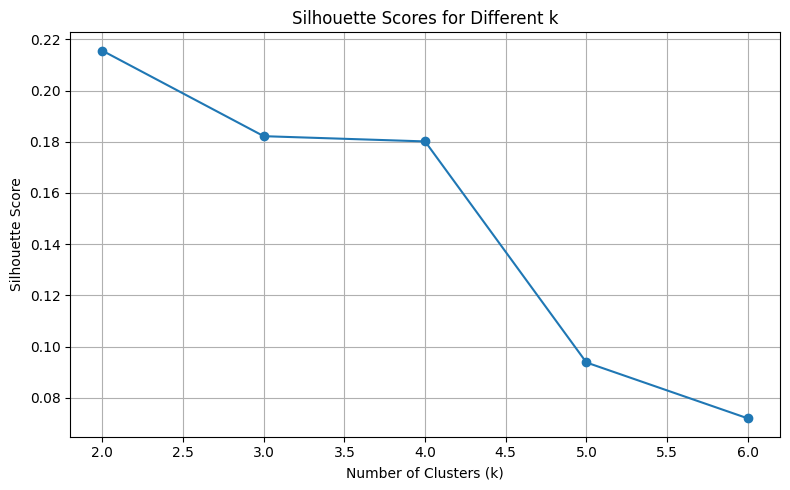

In [ ]:
#Silhouette Score Across Multiple k Values - to determine best k value for kmean clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

scores = []
ks = range(2, 7)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(score_matrix)
    score = silhouette_score(score_matrix, labels)
    scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ks, scores, marker='o')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

Clustering results saved to: /content/drive/MyDrive/clustering_results/final_clustering/book_clusters.csv


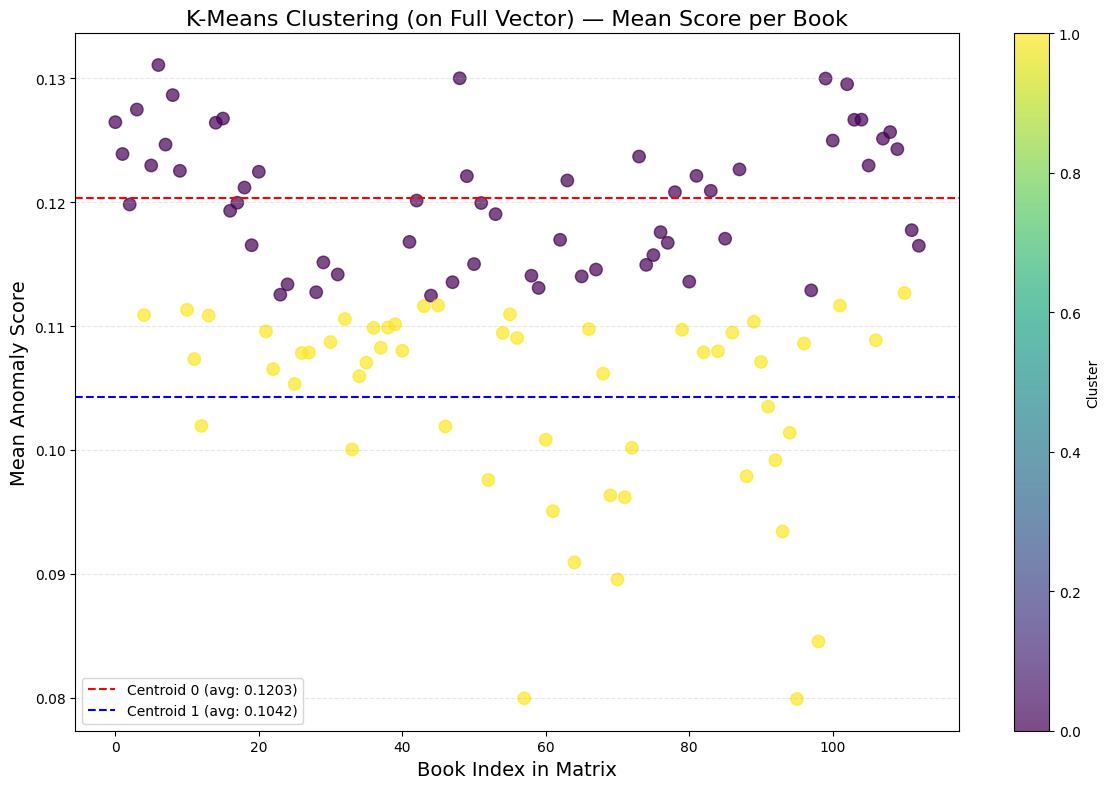

Cluster scatter plot saved to: /content/drive/MyDrive/clustering_results/final_clustering/kmeans_clusters_scatter_plot.png


In [ ]:
import numpy as np
import os


# === Paths ===
FINAL_CLUSTERING_DIR = os.path.join(CLUSTERING_OUTPUT_DIR, "final_clustering")
os.makedirs(FINAL_CLUSTERING_DIR, exist_ok=True)

index_path = "/content/drive/MyDrive/test_group_index.csv"

# === Load data ===
index_df = pd.read_csv(index_path)
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))



# === Run KMeans on full score matrix ===
kmeans = KMeans(n_clusters= 2, random_state=42)
clusters = kmeans.fit_predict(score_matrix)
centroids = kmeans.cluster_centers_

# === Add cluster results ===
score_df["Book"] = books
score_df["Index"] = [index_mapping.get(book, -1) for book in books]
score_df["Cluster"] = clusters

# Save CSV
csv_path = os.path.join(FINAL_CLUSTERING_DIR, "book_clusters.csv")
score_df[["Book", "Index", "Cluster"]].to_csv(csv_path, index=False)
print(f"Clustering results saved to: {csv_path}")

# === Compute mean score per book for plotting ===
mean_scores = score_matrix.mean(axis=1)

# === Plot ===
plt.figure(figsize=(12, 8))
scatter = plt.scatter(range(len(books)), mean_scores, c=clusters, cmap='viridis', s=80, alpha=0.7)

# No annotation on points (removed)
# Previously: displaying book index with plt.text(...)

# Plot horizontal lines for cluster centroid means
centroid_means = centroids.mean(axis=1)
for i, centroid_value in enumerate(centroid_means):
    plt.axhline(centroid_value, linestyle='--',
                color='red' if i == 0 else 'blue',
                label=f'Centroid {i} (avg: {centroid_value:.4f})')

plt.legend()
plt.title("K-Means Clustering (on Full Vector) — Mean Score per Book", fontsize=16)
plt.xlabel("Book Index in Matrix", fontsize=14)
plt.ylabel("Mean Anomaly Score", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()

plot_path = os.path.join(FINAL_CLUSTERING_DIR, "kmeans_clusters_scatter_plot.png")
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"Cluster scatter plot saved to: {plot_path}")



### Clustering on Averaged Scores
Here, we cluster the 32 original books by averaging the normalized anomaly scores across all their segments. This produces a single vector per book, allowing us to analyze broader stylistic patterns at the book level.


In [ ]:
import pandas as pd

score_path = "/content/drive/MyDrive/impostor_results/isolation_forest_output_scores/normalized_score_matrix_avg.csv"
score_df = pd.read_csv(score_path, index_col=0)

books = score_df.index.tolist()
score_matrix = score_df.values  # shape: (num_books, num_scores)

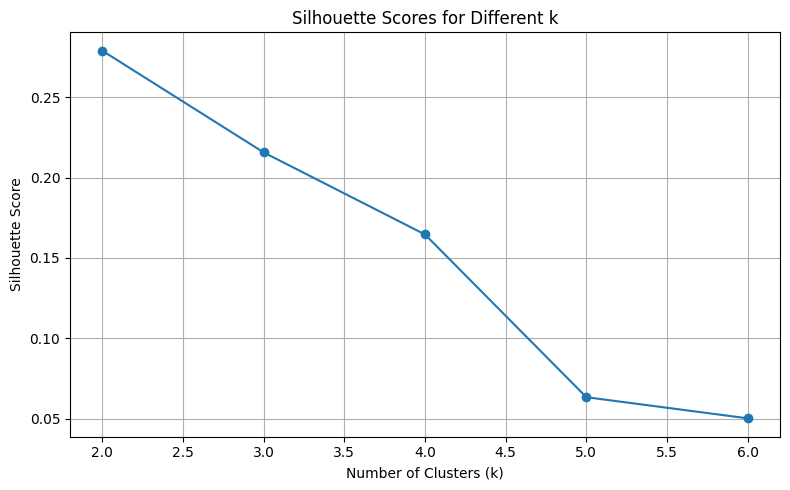

In [ ]:
#Silhouette Score Across Multiple k Values - to determine best k value for kmean clustering

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
ks = range(2, 7)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(score_matrix)
    score = silhouette_score(score_matrix, labels)
    scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ks, scores, marker='o')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

Clustering results saved to: /content/drive/MyDrive/clustering_results/final_clustering/book_clusters_avg.csv


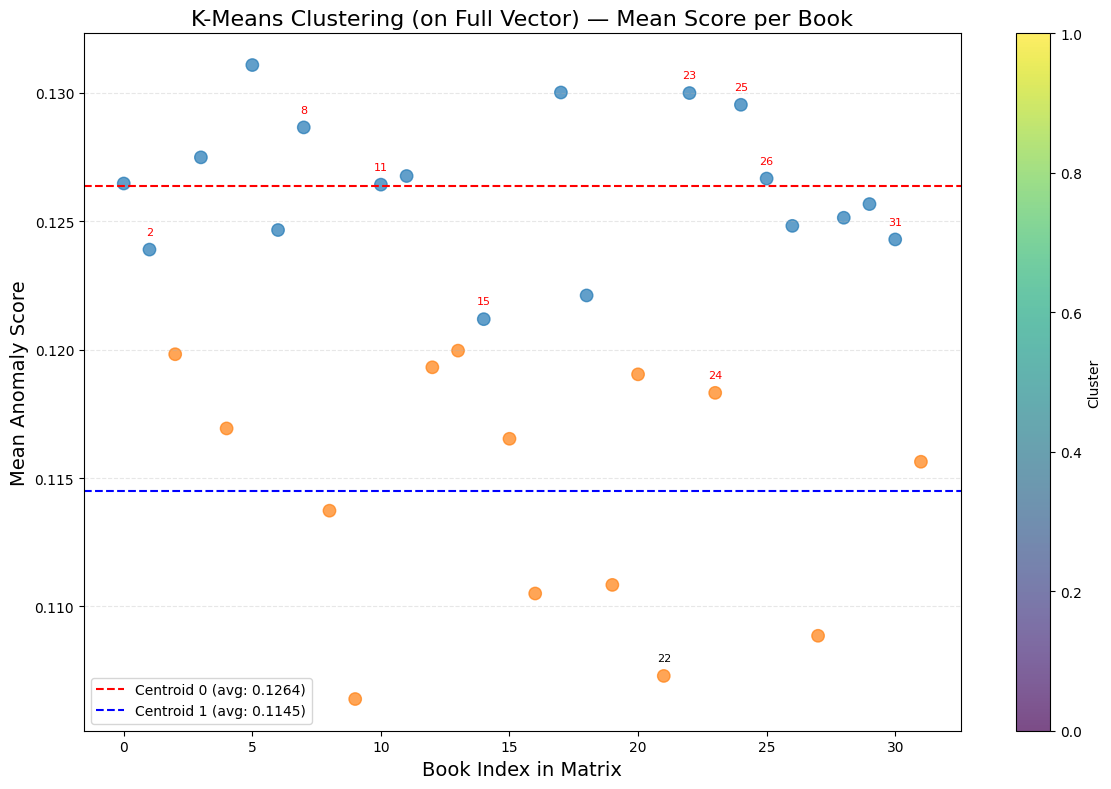

Cluster scatter plot saved to: /content/drive/MyDrive/clustering_results/final_clustering/kmeans_clusters_scatter_plot_avg.png


In [ ]:
import numpy as np
import os


# === Paths ===
FINAL_CLUSTERING_DIR = os.path.join(CLUSTERING_OUTPUT_DIR, "final_clustering")
os.makedirs(FINAL_CLUSTERING_DIR, exist_ok=True)

index_path = "/content/drive/MyDrive/test_group_index_original.csv"

# === Load data ===
index_df = pd.read_csv(index_path)
index_mapping = dict(zip(index_df["Book Name"], index_df["Index"]))


# === Run KMeans on full score matrix ===
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(score_matrix)
centroids = kmeans.cluster_centers_

# === Add cluster results ===
score_df["Book"] = books
score_df["Index"] = [index_mapping.get(book, -1) for book in books]
score_df["Cluster"] = clusters

# Save CSV
csv_path = os.path.join(FINAL_CLUSTERING_DIR, "book_clusters_avg.csv")
score_df[["Book", "Index", "Cluster"]].to_csv(csv_path, index=False)
print(f"Clustering results saved to: {csv_path}")

# === Compute mean score per book for plotting ===
mean_scores = score_matrix.mean(axis=1)

# === Plot ===
plt.figure(figsize=(12, 8))
# Map clusters to specific colors
cluster_colors = ['#1f77b4' if cluster == 0 else '#ff7f0e' for cluster in clusters]
scatter = plt.scatter(range(len(books)), mean_scores, c=cluster_colors, s=80, alpha=0.7)


# === Annotate specific index numbers only ===
highlight_indices = {2, 8, 11, 15, 23, 25, 26, 31, 24}
single_index = 22

for i, (x, y) in enumerate(zip(range(len(books)), mean_scores)):
    index_label = score_df.iloc[i]["Index"]

    if index_label == single_index:
        plt.text(x, y + 0.0005, str(index_label), ha='center', va='bottom', fontsize=8, color='black')
    elif index_label in highlight_indices:
        plt.text(x, y + 0.0005, str(index_label), ha='center', va='bottom', fontsize=8, color='red')


# === Plot horizontal lines for cluster centroid means ===
centroid_means = centroids.mean(axis=1)
for i, centroid_value in enumerate(centroid_means):
    plt.axhline(centroid_value, linestyle='--',
                color='red' if i == 0 else 'blue',
                label=f'Centroid {i} (avg: {centroid_value:.4f})')

plt.legend()
plt.title("K-Means Clustering (on Full Vector) — Mean Score per Book", fontsize=16)
plt.xlabel("Book Index in Matrix", fontsize=14)
plt.ylabel("Mean Anomaly Score", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.colorbar(scatter, label="Cluster")
plt.tight_layout()

plot_path = os.path.join(FINAL_CLUSTERING_DIR, "kmeans_clusters_scatter_plot_avg.png")
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"Cluster scatter plot saved to: {plot_path}")



Cluster centroid plot saved to: /content/drive/MyDrive/clustering_results/final_clustering/cluster_centroid_score_profile_avg.png


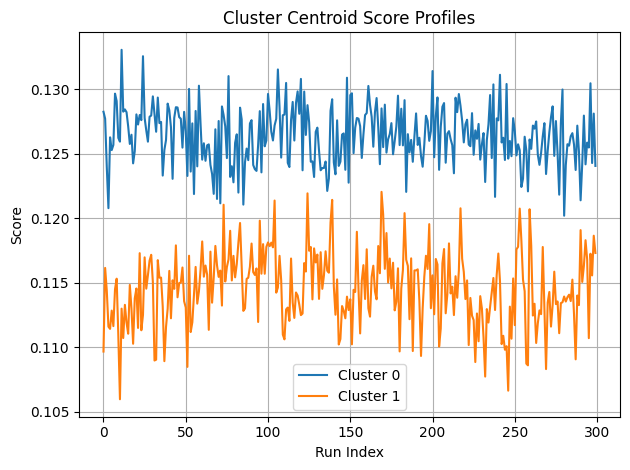

In [ ]:
# === Cluster Centroid Visualization ===

for i, center in enumerate(centroids):
    plt.plot(center, label=f'Cluster {i}')

plt.title("Cluster Centroid Score Profiles")
plt.xlabel("Run Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as PNG
plot_path = os.path.join(FINAL_CLUSTERING_DIR, "cluster_centroid_score_profile_avg.png")
plt.savefig(plot_path, dpi=300)
print(f"Cluster centroid plot saved to: {plot_path}")

plt.show()

